In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage
import torch as th
import networkx as nx
import torch.optim as optim

import snake
import gradImSnake
from loss_MSE_GaussSnake_wGrad_v1 import Loss_MSE_GaussSnake_wGrad

import os
import sys
import logging
import argparse
import itertools
import numpy as np
from copy import deepcopy
from shutil import copyfile
from collections import namedtuple
# from skimage.external import tifffile
from scipy.ndimage.morphology import binary_dilation
from skimage.morphology import skeletonize_3d
import torch
from networktraining import utils
import networktraining as nt
from graph_from_skeleton.graph_from_skeleton import graph_from_skeleton, make_graph
import topoloss4neurons
from topoloss4neurons.networks import UNet
from topoloss4neurons import load_dataset
from scipy.ndimage.morphology import distance_transform_edt

path_apls: /cvlabdata2/home/oner/Snakes


In [3]:
%load_ext autoreload
%autoreload 2

from loss_MSE_GaussSnake_wGrad_v1 import Loss_MSE_GaussSnake_wGrad

In [5]:
def create_X_graph(nnodes,scale,offset):
    # create an X-shaped graph
    g=nx.Graph()
    g.add_node(0,pos=np.array([0.0,0.0])*scale+offset)
    for sign in [( 1, 1), (-1, 1), (-1,-1), ( 1,-1)]:
        prev=0
        for i in range(nnodes):
            n=len(g)
            g.add_node(n,pos=np.array([sign[0]*float(i+1),sign[1]*float(i+1)])*scale+offset)
            g.add_edge(prev,n)
            prev=n
    return g

def drawLine(lbl,begPoint,endPoint):
    # endPoint and begPoint should be np.arrays
    # lbl is an np.array to which the line is rendered
    d=endPoint-begPoint
    mi=np.argmax(np.fabs(d))
    if d[mi]==0: # beginning and end points the same
        lbl[tuple(begPoint.astype(np.int))]=1
    else:
        coef=d/d[mi] # a vector that points from the current to the next pixel
        sz=np.array(lbl.shape) # an array holding a shape not an array of shape
        numsteps=int(abs(d[mi]))+1
        step=int(d[mi]/abs(d[mi])) # +-1
        for t in range(0,numsteps):
            pos=begPoint+coef*t*step
            if np.all(pos<sz) and np.all(pos>=0):
                lbl[tuple(np.round(pos).astype(np.int))]=1
            else:
                print("warning: reqested point",pos,"but the volume size is",sz)
    return lbl

def show(img,title,graph=None):
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    if graph:
        pos = {n:graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray',
                         edge_color='g', font_size=12, font_color='black')
        
def projectGraph(g,axis=0):
    for n in g.nodes:
        dims=len(g.nodes[n]["pos"])
        if axis==-1: axis=dims-1
        inds=np.concatenate([np.arange(0,axis),np.arange(axis+1,dims)],axis=0).astype(int)
        g.nodes[n]["pos"]=g.nodes[n]["pos"][inds]
    
def showProjMin(img,g,dim,title):
    h=g.copy()
    projectGraph(h,axis=dim)
    show(img.min(axis=dim),title,h)
    
def showProjMax(img,g,dim,title):
    h=g.copy()
    projectGraph(h,axis=dim)
    show(img.max(axis=dim),title,h)

def show3D(img,title,g,mode='min'):
    if mode == 'min':
        proj=showProjMin
    elif mode == 'max':
        proj=showProjMax
    else:
        raise ValueError("mode can be min or max, got {}".format(mode))
        
    for dim in range(1): #range(3):
        proj(img,g,dim,title)

def invertCoordinates(g):   
    for n in g.nodes:
        g.nodes[n]["pos"]=g.nodes[n]["pos"][-1::-1]

In [4]:
def process_dataset(dp, in_channels, val=False):
    if in_channels==1:
        image = dp.image[:,:,:,None]
        lbl = dp.dist_labels[:,:,:,None]
        graph = dp.graph
        if val:
            graph = make_graph(graph, True)
    else:
        image = dp.image

    return ExtDataPoint(image, lbl, graph)

def invertCoordinates(g):
    g2 = g.copy()
    for n in g2.nodes:
        g2.nodes[n]["pos"]=g2.nodes[n]["pos"][-1::-1]
    return g2

In [5]:
ExtDataPoint = namedtuple("ExtDataPoint", ['image', 'label', 'graph'])

In [7]:
dataset_training = load_dataset("neuron", "training", size="train", labels="all", each=1, threshold=15, graph=True)

6.t7.npy
14.t7.npy
17.t7.npy
3.t7.npy
5.t7.npy
0.t7.npy
12.t7.npy
13.t7.npy
1.t7.npy
8.t7.npy


In [8]:
ft = lambda dp: process_dataset(dp,1, False)
dataset_training = [ft(dp) for dp in dataset_training]

In [2]:
import time
class TrainingStep(object):

    def __init__(self, batch_size, crop_size, dataset, probas, snakes, snakes_start=0):
        self.batch_size = batch_size
        self.crop_size = crop_size
        self.dataset = dataset
        self.probas = probas
        self.snakes = snakes

        self.snakes_start = snakes_start

    def __call__(self, iterations, network, optimizer, lr_scheduler, loss_function, loss_function2):

        replace = True if len(self.dataset)<self.batch_size else False
        minibatch = [self.dataset[200]]

        images = [dp.image for dp in minibatch]
        labels = [dp.label for dp in minibatch]
        graphs = [invertCoordinates(dp.graph) for dp in minibatch]
#         graphs2 = [invertCoordinates(graph) for graph in graphs]
        # --- augmentation ---
        f = []
#         f.append( lambda sample: nt.crop(sample, self.crop_size, "random") )
#         f.append( lambda sample: nt.random_flip(sample, axis=(0,1,2), p=(0.5,0.5,0.5)) )
#         images, labels = nt.process_in_batch(f, images, labels)

        #f = lambda image: nt.random_intensity_remap(image, 0.1)
        #images = nt.process_in_batch(f, images)
        # --- augmentation ---

        images  = np.transpose(np.float32(images), (0,4,1,2,3))
        labels  = np.transpose(np.float32(labels), (0,4,1,2,3))

        images  = nt.to_torch(images)

        preds = network(images)

        t = time.time()
        if (iterations > self.snakes_start):
            loss,img = loss_function(preds, graphs)
        else:
            labels  = nt.to_torch(labels)
            loss = loss_function2(preds, labels)
        print(time.time()-t)
        loss_v = float(nt.from_torch(loss))

        if np.isnan(loss_v) or np.isinf(loss_v):
            return {"loss": loss_v,
                    "pred": nt.from_torch(pred),
                    "labels": nt.from_torch(labels)}

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        if lr_scheduler is not None:
            lr_scheduler.step()

        return {"loss": float(loss_v)}, img, labels

In [231]:
training_step = TrainingStep(1,
                             tuple([96,96,96]),
                             dataset_training,
                             None,
                             True,
                             100)

In [19]:
th.cuda.set_device(0)

In [21]:
__c__ = nt.yaml_read("main.config")
output_path = __c__["output_path"]
dataset = __c__["dataset"]
batch_size = __c__["batch_size"]
threshold = __c__["threshold"]
snakes = __c__["snakes"]

In [133]:
network = UNet(in_channels=__c__["in_channels"],
                   m_channels=__c__["m_channels"],
                   out_channels=__c__["num_classes"],
                   n_convs=__c__["n_convs"],
                   n_levels=__c__["n_levels"],
                   dropout=__c__["dropout"],
                   batch_norm=__c__["batch_norm"],
                   upsampling=__c__["upsampling"],
                   pooling=__c__["pooling"],
                   three_dimensional=__c__["three_dimensional"])

In [134]:
network.load_state_dict(torch.load("./brain_logs/log_ns_3d_3steps_2conv_pod_apls5_nobeta5_highdecaylate5k/network_besttcor.pickle"))

<All keys matched successfully>

In [23]:
network.train(True)
optimizer = torch.optim.Adam(network.parameters(), lr=__c__["lr"],
                             weight_decay=__c__["weight_decay"])

In [1]:
stepsz=0.5
alpha=0
beta=0
crop=[slice(0,96), slice(0,96), slice(0,96)]
fltrstdev=0.5
extparam=1
nsteps=10
ndims=3
cropsz=[32,32,32]
dmax=15
maxedgelength=5
extgradfac=2.0

loss_function=Loss_MSE_GaussSnake_wGrad2(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                        cropsz,dmax,maxedgelength,extgradfac)

loss_function2=nt.losses.MSELoss()

NameError: name 'Loss_MSE_GaussSnake_wGrad2' is not defined

In [232]:
l,m,m2 = training_step(10000000,network,optimizer,None,loss_function,loss_function2)
print(l)

52
0.8635659217834473
{'loss': 0.37164899706840515}


In [200]:
for j,d in enumerate(dataset_training):
    for i in range(len(d.graph.nodes)):
        ranks = len(d.graph[i])
        if ranks == 0:
            print(j)

1
22
23
28
31
34
40
43
46
49
147
161
168
178
179
195
200
203
212
215
216
223
224
225
228
235
236
237
268
280
333
362
374
384
385
387
390
395
399
407
408
444
447
459
473
474


In [218]:
dataset_training[200].graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51))

In [202]:
d = dataset_training[1].graph
for i in range(len(d.nodes)):
    ranks = len(d[i])
    if ranks == 0:
        print(ranks)

0


In [198]:
d.nodes[1]

{'pos': (20.0, 35.0, 3.0)}

In [63]:
network.down_path[0].layers[0].weight[0].dtype

torch.float32

In [83]:
type(dataset_training[0].graph.nodes[0]['pos'][0])

float

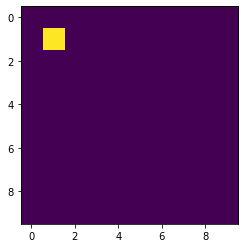

In [177]:
%matplotlib inline
plt.imshow(dataset_training[200].label.min(0)[50:60,:10,0]==0)

In [170]:
for i in range(52):
    print(dataset_training[200].graph[i])

{1: {}}
{0: {}, 3: {}}
{4: {}}
{1: {}, 5: {}}
{2: {}, 6: {}}
{3: {}, 7: {}}
{4: {}, 10: {}}
{5: {}, 8: {}}
{7: {}, 9: {}}
{8: {}, 12: {}}
{6: {}, 11: {}}
{10: {}, 14: {}}
{9: {}, 13: {}}
{12: {}, 16: {}}
{11: {}, 15: {}}
{14: {}, 18: {}}
{13: {}, 17: {}}
{16: {}, 20: {}}
{15: {}, 19: {}}
{18: {}, 22: {}}
{17: {}, 21: {}}
{20: {}, 23: {}}
{19: {}, 24: {}}
{21: {}, 25: {}}
{22: {}, 26: {}}
{23: {}}
{24: {}, 27: {}}
{26: {}, 28: {}}
{27: {}, 29: {}}
{28: {}, 30: {}}
{29: {}, 31: {}}
{30: {}, 32: {}}
{31: {}, 33: {}}
{32: {}, 34: {}}
{33: {}, 35: {}}
{34: {}, 36: {}}
{35: {}, 37: {}}
{36: {}, 38: {}}
{37: {}, 39: {}}
{38: {}, 40: {}}
{39: {}, 41: {}}
{40: {}, 42: {}}
{41: {}, 43: {}}
{42: {}, 44: {}}
{43: {}, 45: {}}
{44: {}, 46: {}}
{45: {}, 47: {}}
{46: {}, 48: {}}
{47: {}, 49: {}}
{48: {}, 50: {}}
{49: {}}
{}


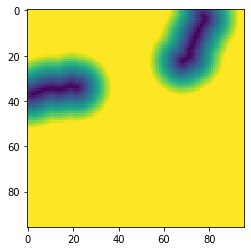

In [237]:
plt.imshow(m.min(0))

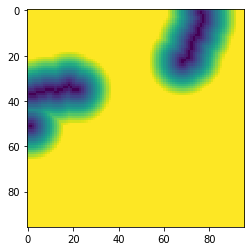

In [238]:
plt.imshow(m2[0,0].min(0))

In [155]:
for i,d in enumerate(dataset_training):
#     print(len(d.graph.nodes))
    if len(d.graph.nodes) == 52:
        print(i)

200


In [63]:
fltr =gradImSnake.makeGaussEdgeFltr(0.5,2)
fltrt=th.from_numpy(fltr).type(th.float32)

In [64]:
gimg=gradImSnake.cmptGradIm(pred,fltrt)
gimg2=gradImSnake.cmptGradIm(pred2,fltrt)
gimg3=gradImSnake.cmptGradIm(pred3,fltrt)

In [65]:
gimgf = gradImSnake.cmptGradIm(pred+pred2+pred3,fltrt)

In [67]:
gimgf.size()

torch.Size([1, 2, 100, 100])

In [68]:
gimgf2 = gimg+gimg2+gimg3

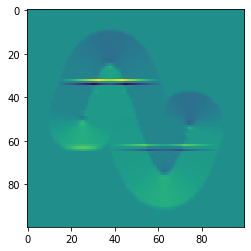

In [73]:
plt.imshow(gimgf2.detach().numpy()[0,0])

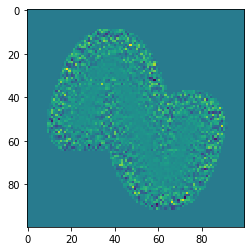

In [75]:
plt.imshow(gimgf.detach().numpy()[0,0] - gimgf2.detach().numpy()[0,0])

In [3]:
import torch as th
import torch.nn as nn
import Codes.Losses.gradImSnake as gradImSnake
from Codes.Losses.losses import SnakeFastLoss as Loss_MSE_GaussSnake_wGrad

class Loss_MSE_GaussSnake_wGrad2(nn.Module):
    def __init__(self, stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                       cropsz,dmax,maxedgelen,extgradfac):
        super(Loss_MSE_GaussSnake_wGrad2,self).__init__()
        self.stepsz=stepsz
        self.alpha=alpha
        self.beta=beta
        self.fltrstdev=fltrstdev
        self.ndims=ndims
        self.cropsz=cropsz
        self.dmax=dmax
        self.maxedgelen=maxedgelen
        self.extgradfac=extgradfac
        self.nsteps=nsteps

        self.fltr =gradImSnake.makeGaussEdgeFltr(self.fltrstdev,self.ndims)
        self.fltrt=th.from_numpy(self.fltr).type(th.float32)

        self.iscuda=False

    def cuda(self):
        super(Loss_MSE_GaussSnake_wGrad,self).cuda()
        self.fltrt=self.fltrt.cuda()
        self.iscuda=True
        return self

    def forward(self,pred_dmap,lbl_graphs,crops=None):
    # in forward we move the snake
        pred_=pred_dmap[0] #.detach()
        pred_2=pred_dmap[1]
        pred_3=pred_dmap[2]
        gimg=gradImSnake.cmptGradIm(pred_,self.fltrt)
        gimg2=gradImSnake.cmptGradIm(pred_2,self.fltrt)
        gimg3=gradImSnake.cmptGradIm(pred_3,self.fltrt)
        gimg*=self.extgradfac
        gimg2*=self.extgradfac
        gimg3*=self.extgradfac
        snake_dmap=[]

        for i,lg in enumerate(zip(lbl_graphs,gimg,gimg2,gimg3)):
            l = lg[0]
            g = lg[1]
            g2 = lg[2]
            g3 = lg[3]
            if crops:
                crop = crops[i]
            else:
                crop=[slice(0,s) for s in g.shape[1:]]
            s=gradImSnake.GradImSnake(l,crop,self.stepsz,self.alpha,
                                      self.beta,self.ndims,(g+g2+g3)/3)
            if self.iscuda: s.cuda()
            # first move the snake, to optimizae it
            s.optim(self.nsteps)
            # then render its distance map to later use it for the calculation of the loss
            # of the predication (normally UNet)
            dmap=s.renderDistanceMap(g.shape[1:],self.cropsz,self.dmax,
                                     self.maxedgelen)
            if i == 0:
                show(dmap[0,0], "dmap of the snake", l)
            snake_dmap.append(dmap)

        snake_dm=th.stack(snake_dmap,0).unsqueeze(1)
        loss=th.pow(pred_dmap[0]-snake_dm,2).mean()
        loss+=th.pow(pred_dmap[1]-snake_dm,2).mean()
        loss+=th.pow(pred_dmap[2]-snake_dm,2).mean()
                  
        self.snake=s
        self.gimg=gimg
        
        return loss

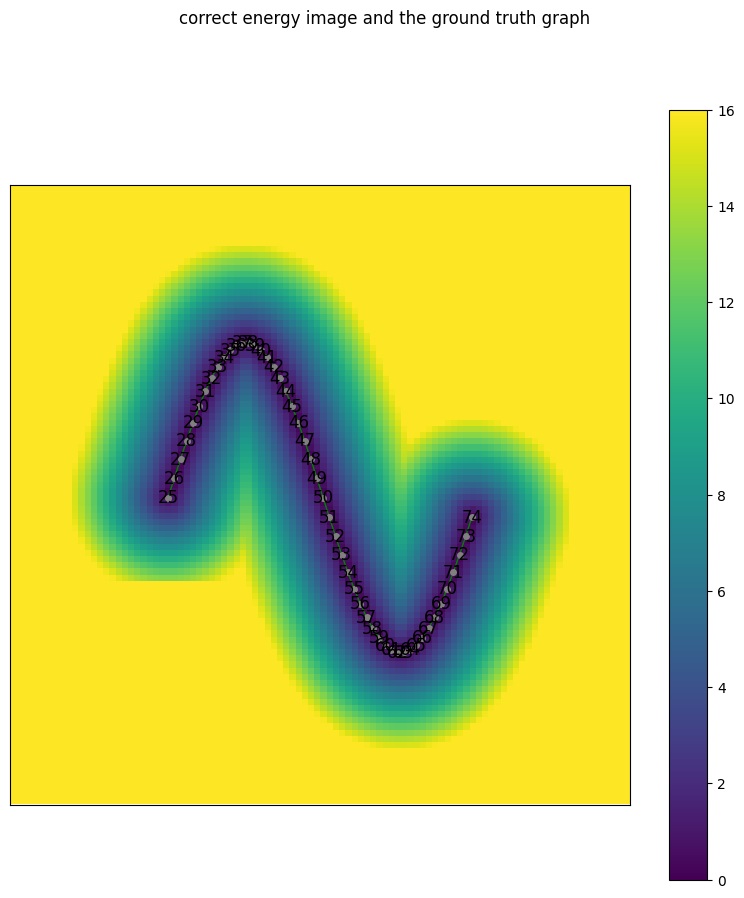

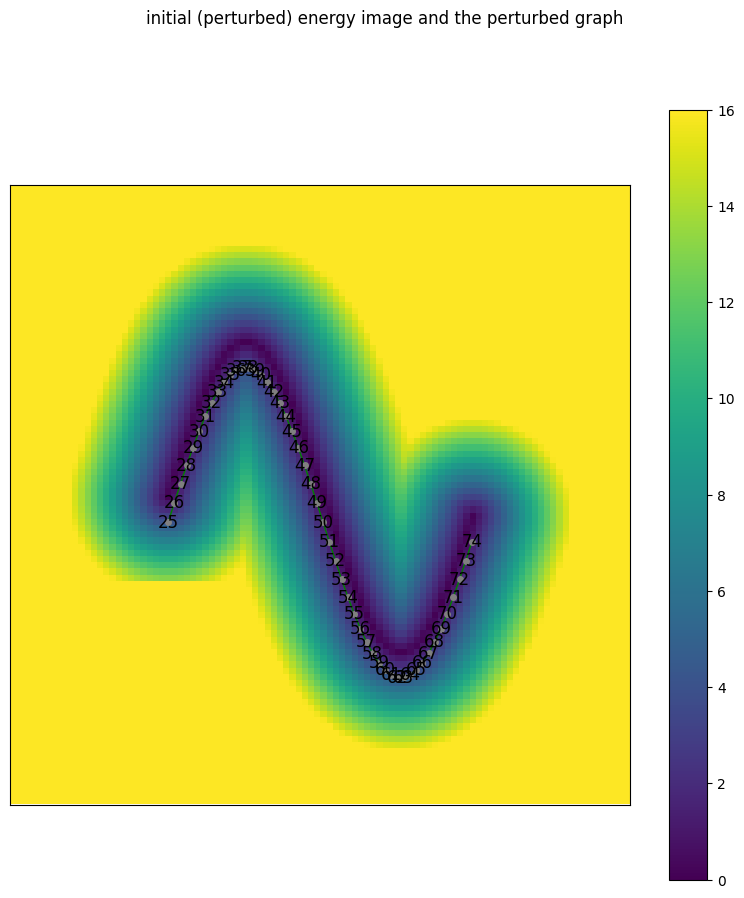

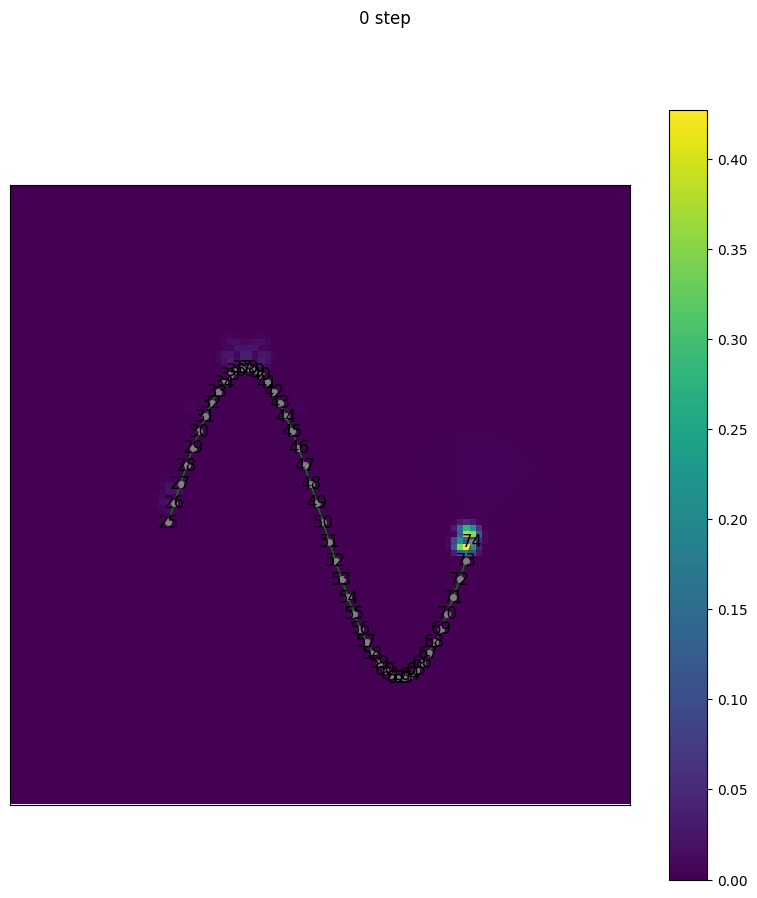

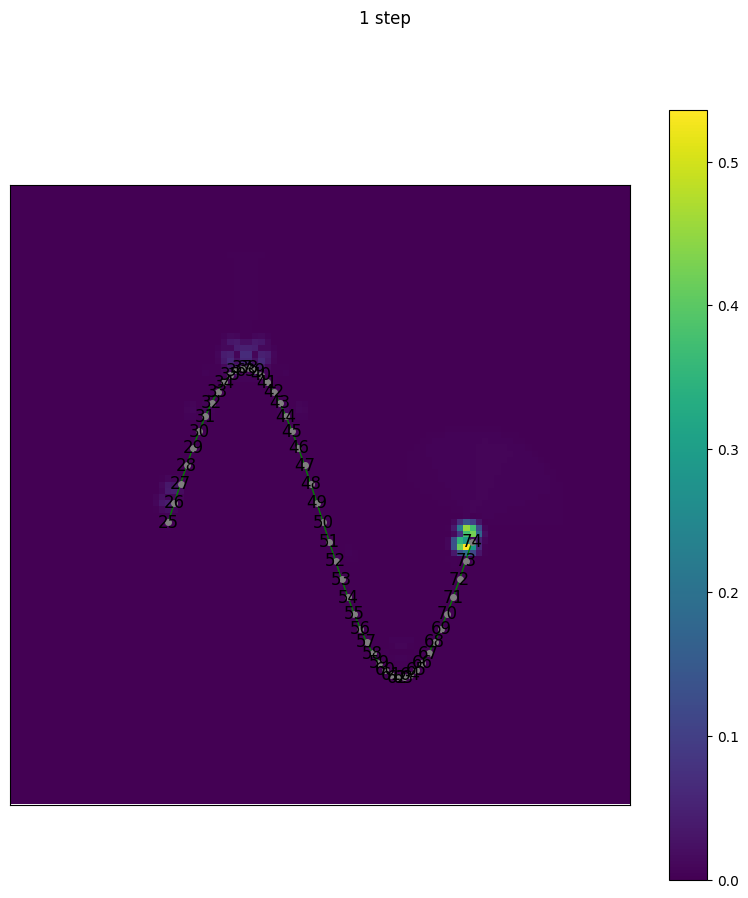

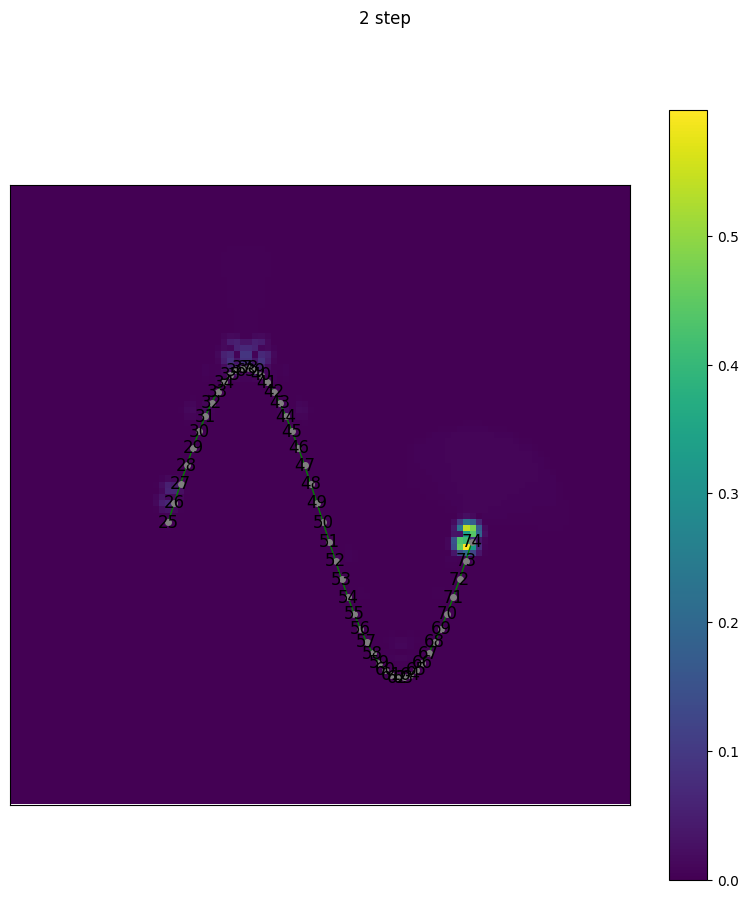

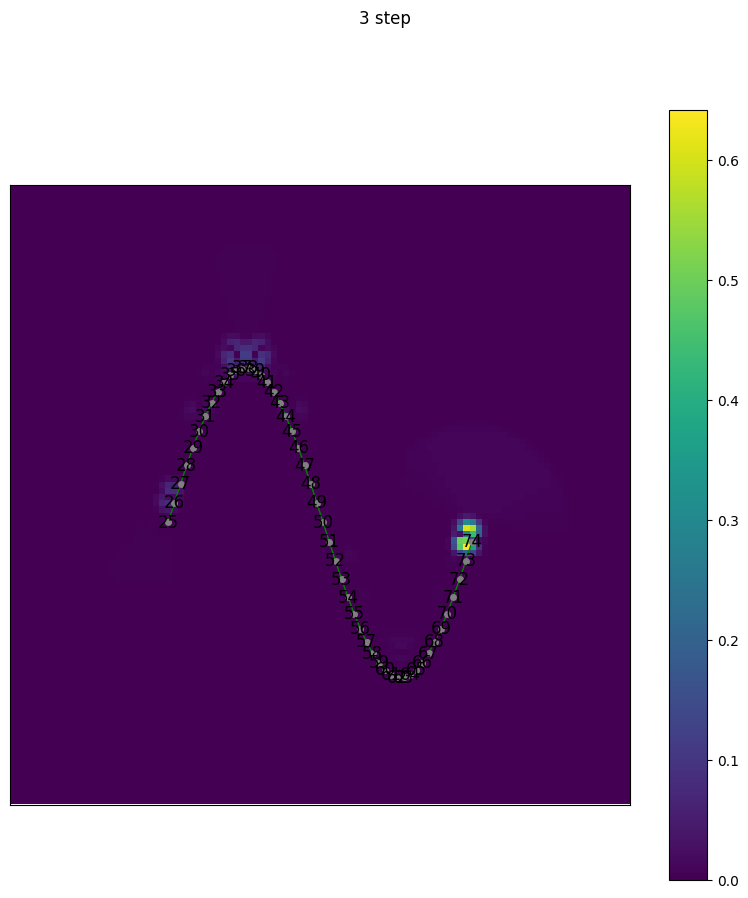

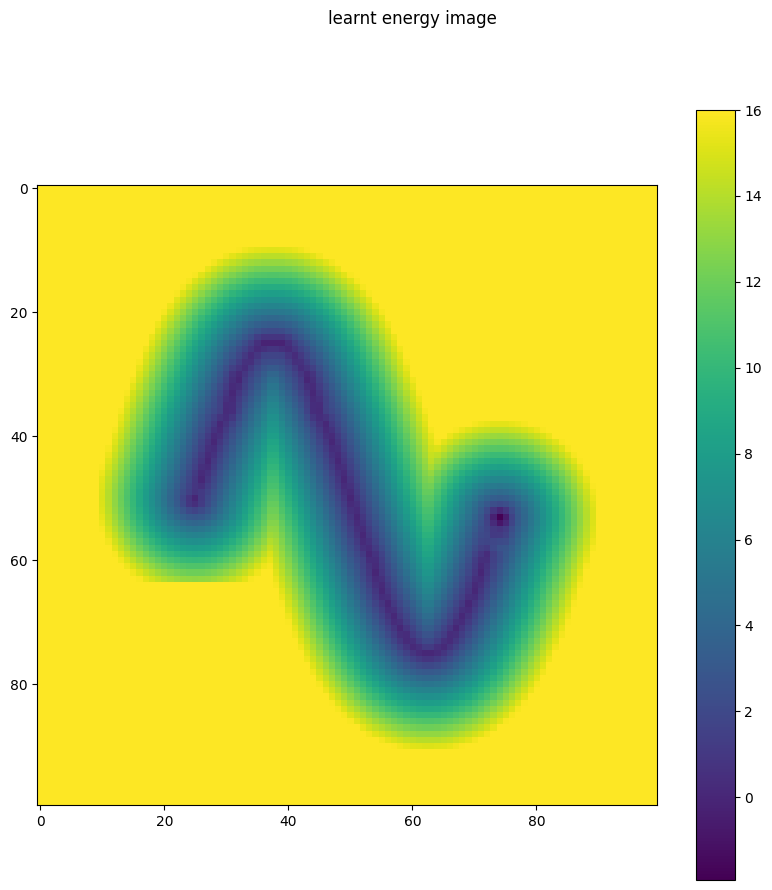

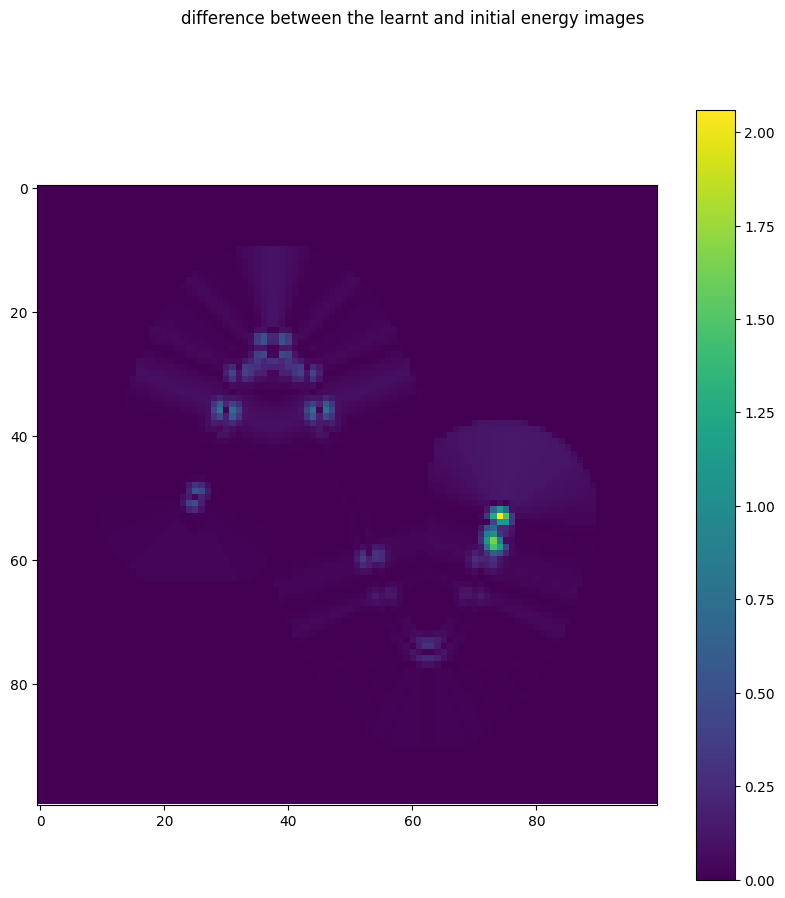

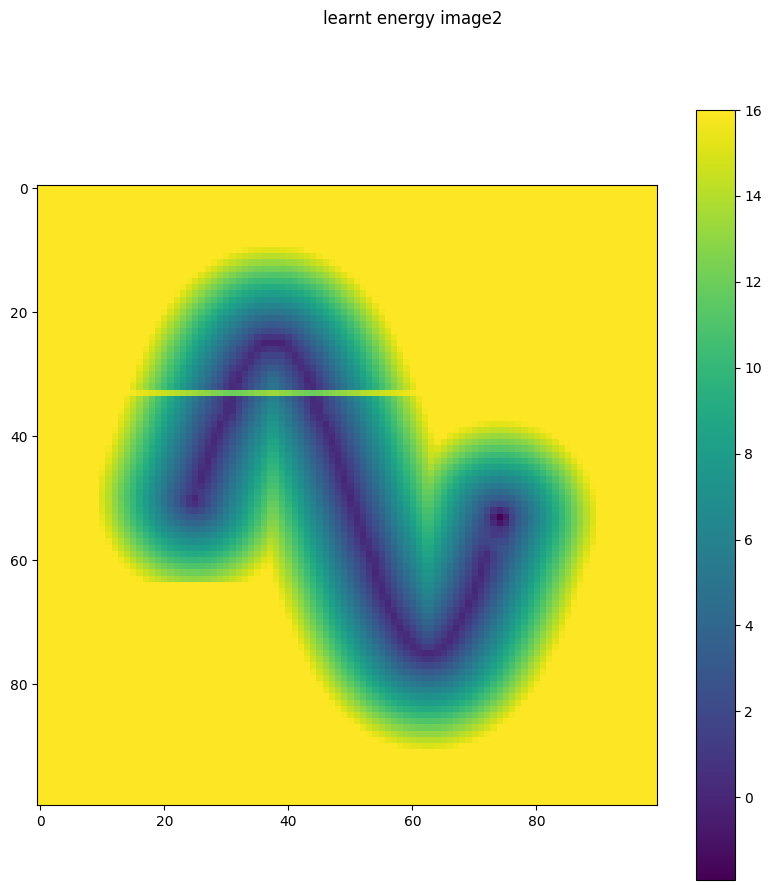

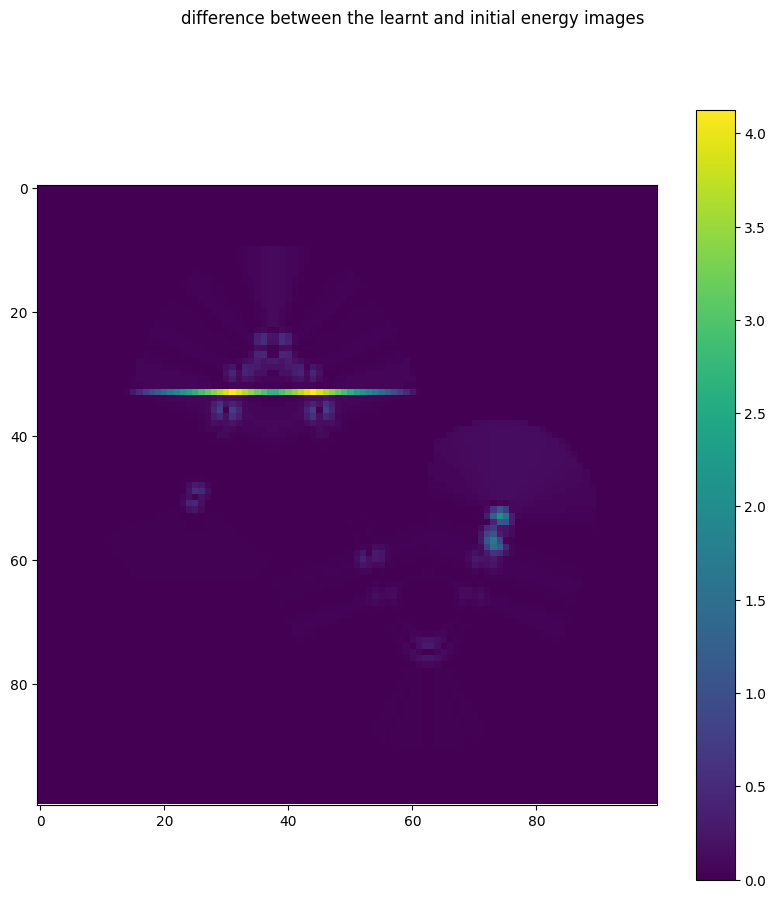

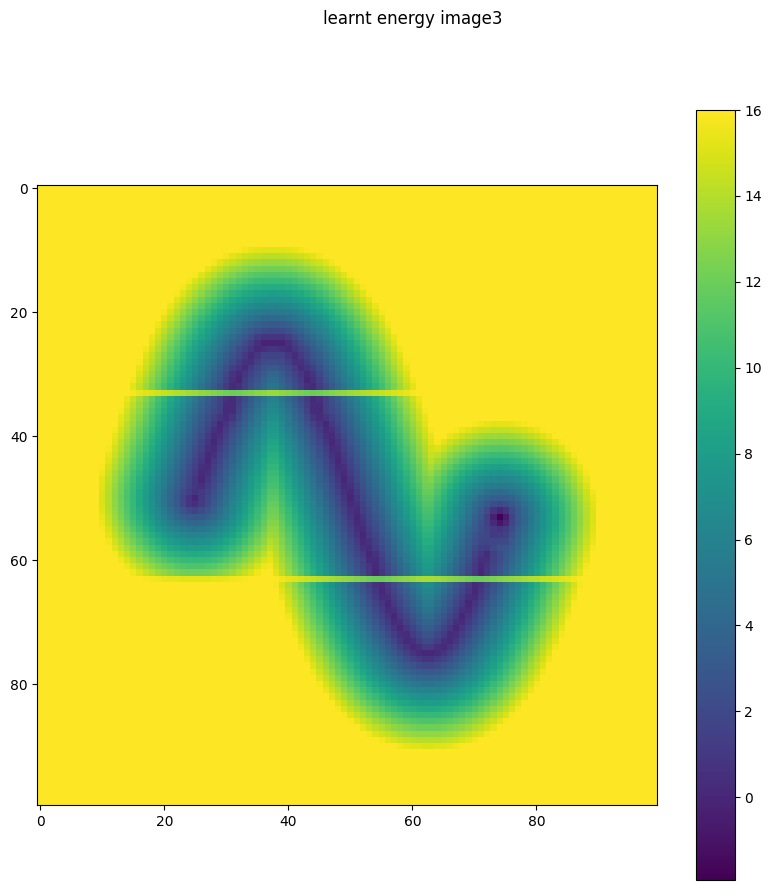

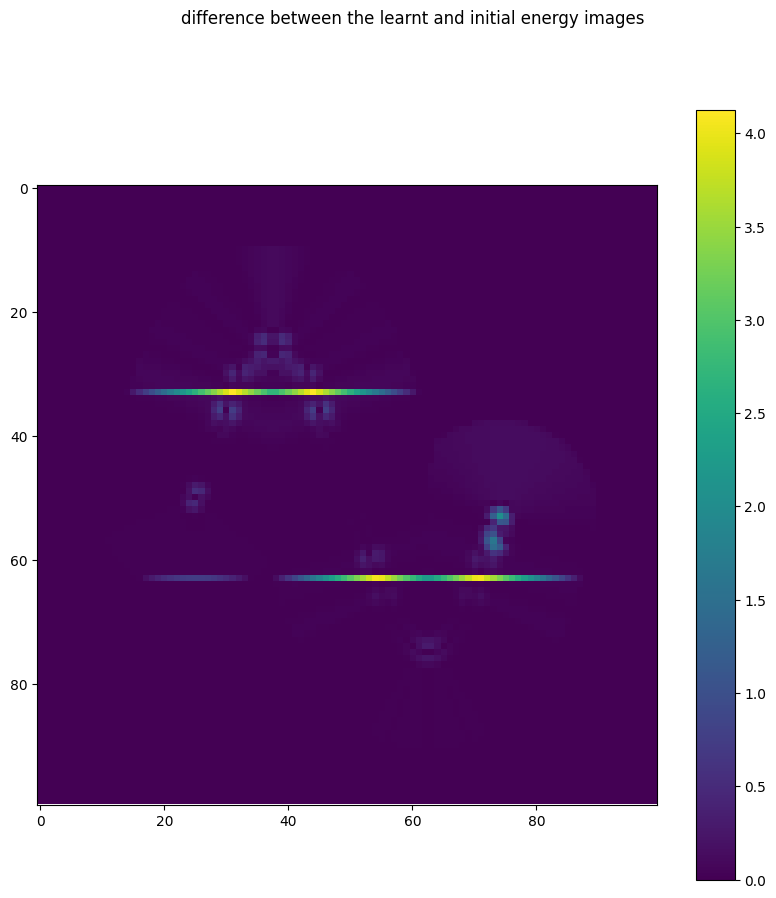

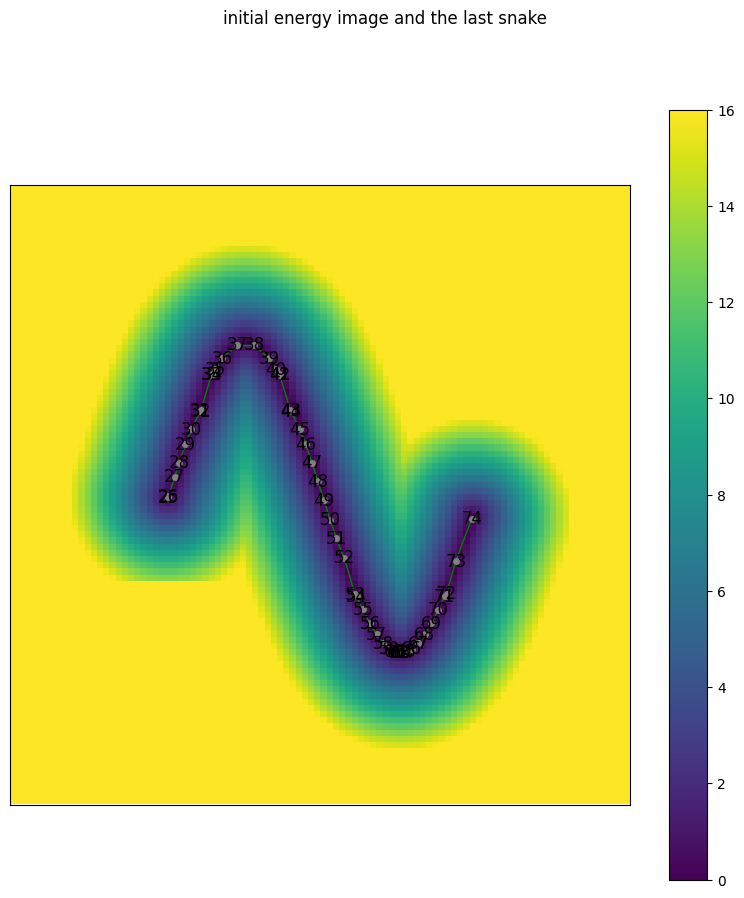

In [33]:
# sine-shaped snake
%matplotlib inline
import time
from math import sin,pi
from torch import optim
import networkx as nx
import numpy as np
import Codes.Losses.snake as snake
import matplotlib.pyplot as plt

# the ground truth graph is a sinusoid
g=nx.Graph()
for i in range(25,75):
    g.add_node(i,pos=np.array([sin(i*2*pi/50.0)*25+50,i]))
    if i>25:
        g.add_edge(i,i-1)
        
stepsz=0.33
alpha=0
beta=0
crop=[slice(0,200), slice(0,200)]
ndims=2

s=snake.Snake(g,crop,stepsz,alpha,beta,ndims)  

size=[100,100]
cropsz=[16,16]
dmax=16
maxedge=4
 
pred_perfect=s.renderDistanceMap(size,cropsz,dmax,maxedge) 
show(pred_perfect.numpy(),"correct energy image and the ground truth graph",g)
plt.colorbar()

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
pred_initial3=pred_perfect.clone()[None,None]

pred_initial2[:,:,33:34,:]=16.0
pred_initial3[:,:,33:34,:]=16.0
pred_initial3[:,:,63:64,:]=16.0

pred=pred_initial.clone()
pred2=pred_initial2.clone()
pred3=pred_initial3.clone()
pred.requires_grad_(True)
pred2.requires_grad_(True)
pred3.requires_grad_(True)

# predf = (pred+pred2+pred3)/3
# predf.requires_grad_(True)
# perturb the ground truth graph
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([4,0]) 

show(pred[0][0].detach().numpy(),"initial (perturbed) energy image and the perturbed graph",g)
plt.colorbar()

fltrstdev=1.0

opt = optim.SGD([pred,pred2,pred3], lr=5.0, momentum=0.0)

extgradfac=1.0
nsteps=20

loss=Loss_MSE_GaussSnake_wGrad2(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                cropsz,dmax,maxedge,extgradfac)

for i in range(300):
    opt.zero_grad()
    t = time.time()
    # in forward we move the snake
    l=loss.forward(th.stack((pred,pred2,pred3),axis=0),[g])
    l.backward()
    opt.step()

show(pred[0][0].detach().numpy(),"learnt energy image")
plt.colorbar()
show(th.abs(pred-pred_initial)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar()

show(pred2[0][0].detach().numpy(),"learnt energy image2")
plt.colorbar()
show(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar()

show(pred3[0][0].detach().numpy(),"learnt energy image3")
plt.colorbar()
show(th.abs(pred3-pred_initial3)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar()

final_pred=pred.detach()
show(pred_initial[0][0].numpy(),"initial energy image and the last snake",
     loss.snake.getGraph())
plt.colorbar()
#show(loss.gimg[0][0],"aa")
#show(loss.gimg[0][1],"bb")

In [20]:
import torch as th
import torch.nn as nn
import Codes.Losses.gradImSnake as gradImSnake
from Codes.Losses.losses import SnakeFastLoss as Loss_MSE_GaussSnake_wGrad

class Loss_MSE_GaussSnake_wGrad3(nn.Module):
    def __init__(self, stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                       cropsz,dmax,maxedgelen,extgradfac):
        super(Loss_MSE_GaussSnake_wGrad3,self).__init__()
        self.stepsz=stepsz
        self.alpha=alpha
        self.beta=beta
        self.fltrstdev=fltrstdev
        self.ndims=ndims
        self.cropsz=cropsz
        self.dmax=dmax
        self.maxedgelen=maxedgelen
        self.extgradfac=extgradfac
        self.nsteps=nsteps

        self.fltr =gradImSnake.makeGaussEdgeFltr(self.fltrstdev,self.ndims)
        self.fltrt=th.from_numpy(self.fltr).type(th.float32)

        self.iscuda=False

    def cuda(self):
        super(Loss_MSE_GaussSnake_wGrad,self).cuda()
        self.fltrt=self.fltrt.cuda()
        self.iscuda=True
        return self

    def forward(self,pred_dmap,lbl_graphs, index, crops=None):
    
        pred_=pred_dmap#[0] #.detach()
        """ pred_2=pred_dmap[1]
        pred_3=pred_dmap[2] """
        gimg=gradImSnake.cmptGradIm(pred_,self.fltrt)
        """ gimg2=gradImSnake.cmptGradIm(pred_2,self.fltrt)
        gimg3=gradImSnake.cmptGradIm(pred_3,self.fltrt) """
        gimg*=self.extgradfac
        """ gimg2*=self.extgradfac
        gimg3*=self.extgradfac """
        snake_dmap=[]

        if index == 0:
            show(gimg[0][0].detach().numpy(),"gradient of image calculated from cmptGradIm",lbl_graphs[0])
            plt.colorbar()
            print(len(lbl_graphs), type(lbl_graphs))
            print(len(gimg), type(gimg))
        
        for i,lg in enumerate(zip(lbl_graphs,gimg)):
            # l neyi temsil ediyor?
            l = lg[0]
            g = lg[1]
            """ g2 = lg[2]
            g3 = lg[3] """
            if crops:
                crop = crops[i]
            else:
                crop=[slice(0,s) for s in g.shape[1:]]
            s=gradImSnake.GradImSnake(l,crop,self.stepsz,self.alpha,
                                      self.beta,self.ndims,g)
            if self.iscuda: s.cuda()
            # first move the snake, to optimizae it
            ###################
            # do we move each node separately?
            # böyle değilmiş, hepsini aynı anda hareket ettirerek optimize ediyoruz.
            ###################
            s.optim(self.nsteps)
            # then render its distance map to later use it for the calculation of the loss
            # of the predication (normally UNet)
            dmap=s.renderDistanceMap(g.shape[1:],self.cropsz,self.dmax,
                                     self.maxedgelen)
            """ if index < 10:
                show(dmap.detach(), "dmap of the snake")
                plt.colorbar() """
            # bunları neden arraya atıp en sonunda hepsini kullanarak (ve meani alıp) lossu hesaplaıyoruz
            # normalde 3 farklı örnek üzerinden ilerlendiği için böyle sanırım
            snake_dmap.append(dmap)
        if index == 0:
            # içinde birden fazla mı dmap var
            # varsa neden?
            # yokmuş
            print(len(snake_dmap))
        # why do we use the array of snake dmaps?
        # yine varianceı azaltmak için mi?
        # tek map varmış
        snake_dm=th.stack(snake_dmap,0).unsqueeze(1)
        loss=th.pow(pred_dmap-snake_dm,2).mean()
        """ loss+=th.pow(pred_dmap[1]-snake_dm,2).mean()
        loss+=th.pow(pred_dmap[2]-snake_dm,2).mean() """
        # original snake isn't changed
        #we attach the snake we moved to the loss
        self.snake=s
        self.gimg=gimg
        
        return loss

1 <class 'list'>
1 <class 'torch.Tensor'>
1


KeyboardInterrupt: 

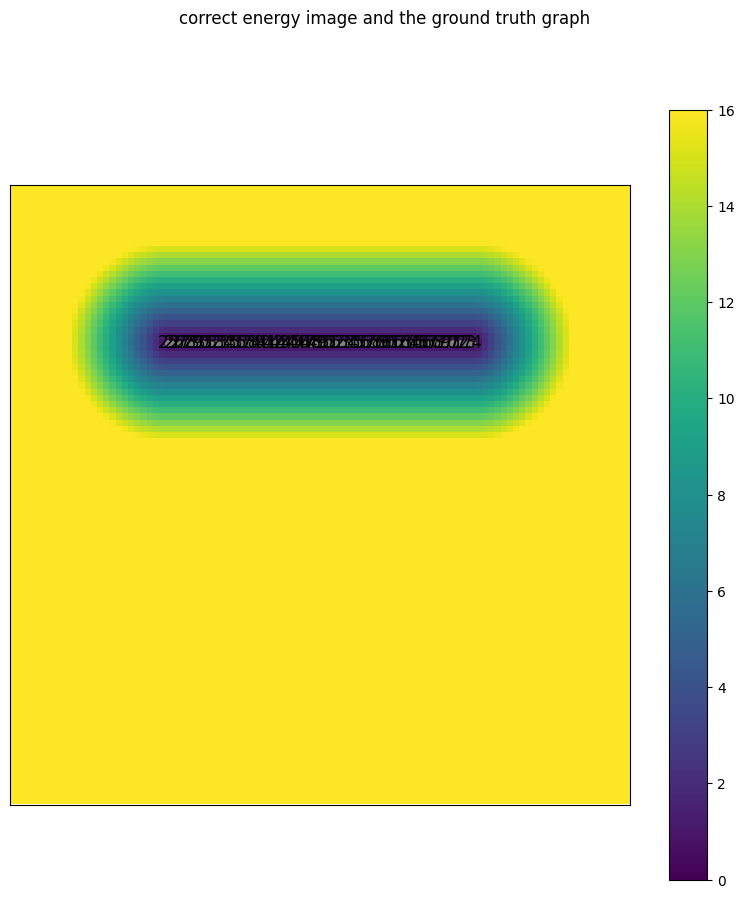

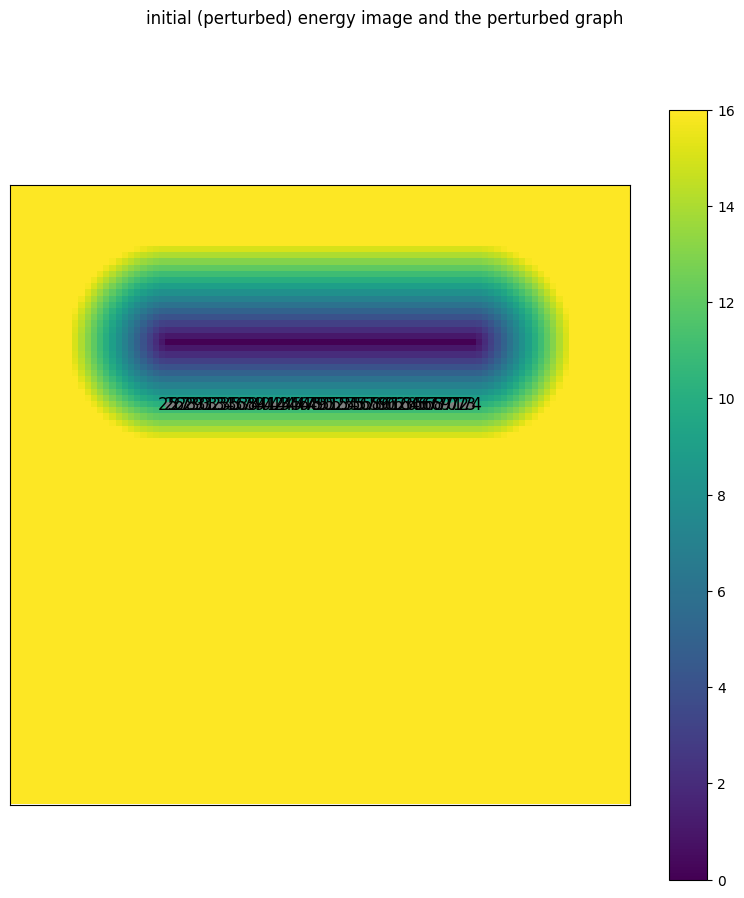

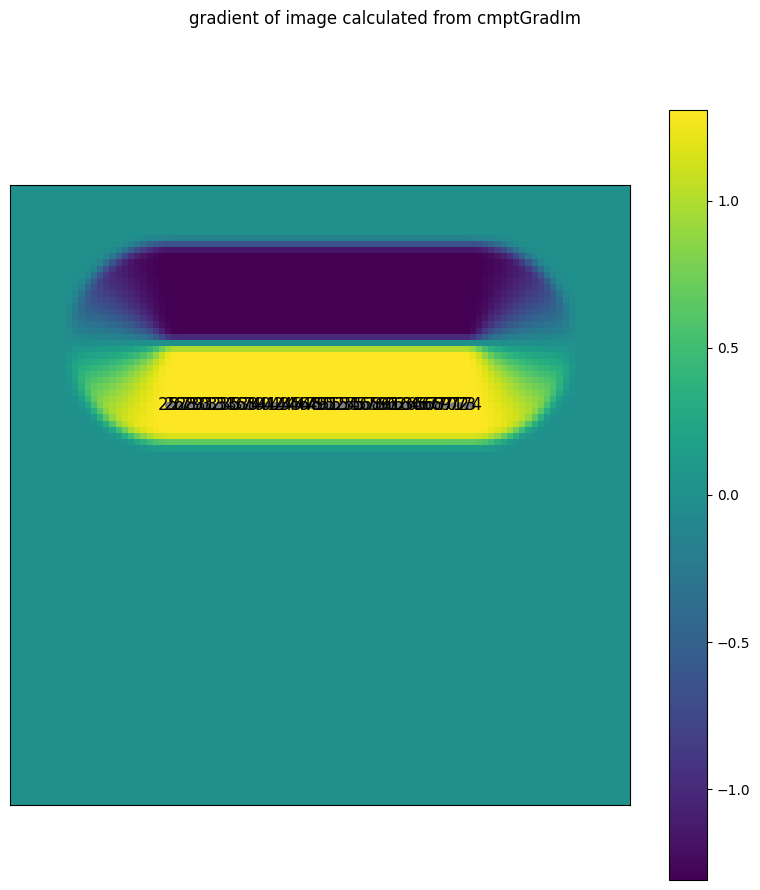

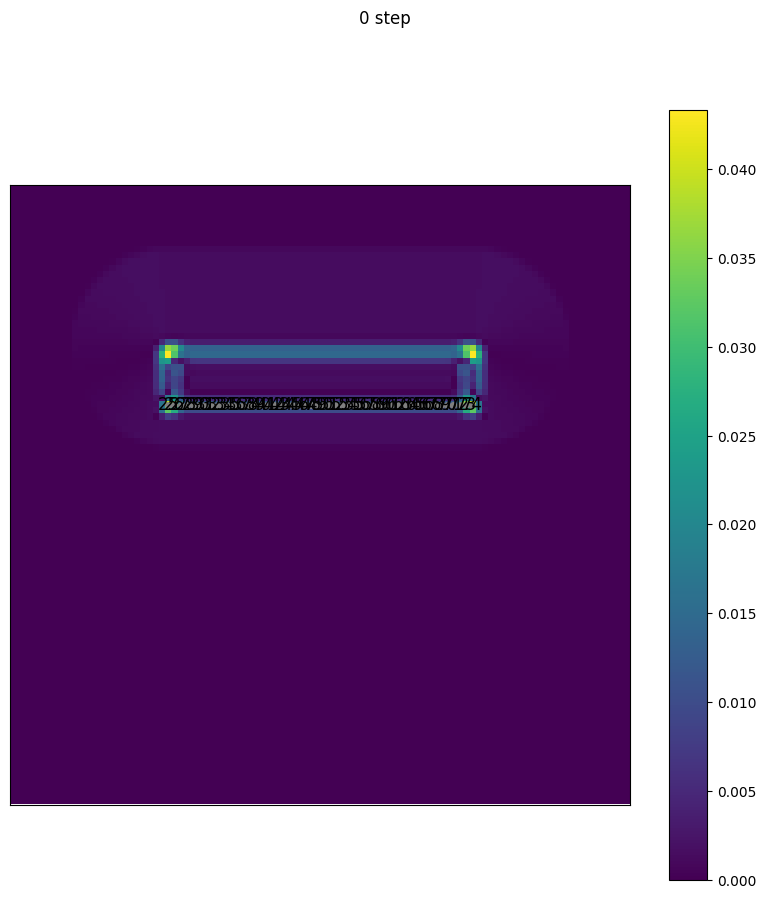

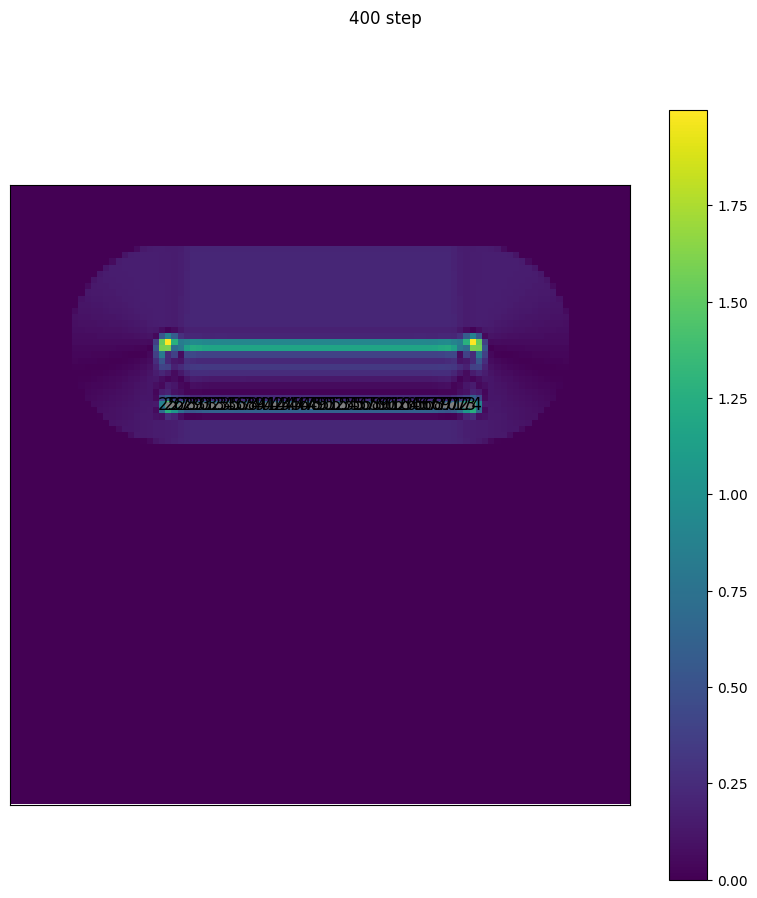

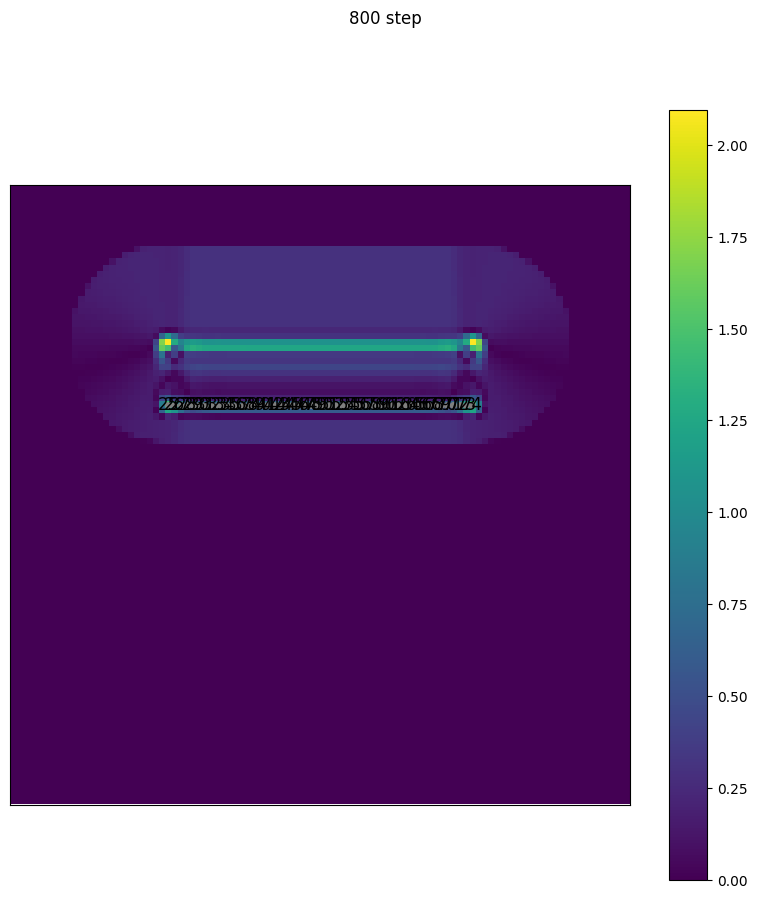

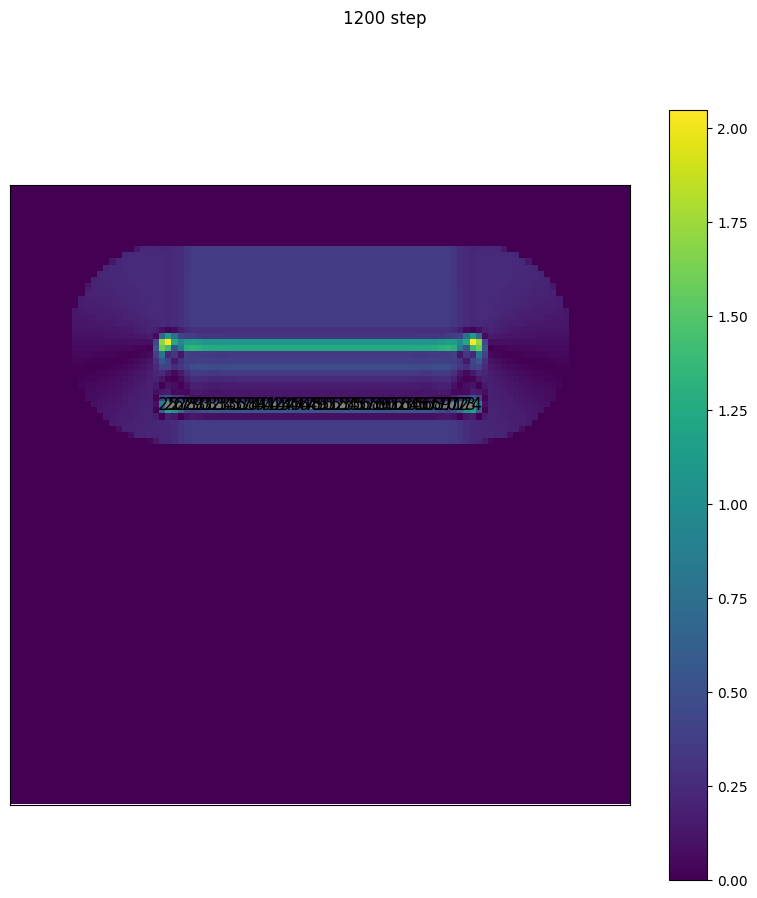

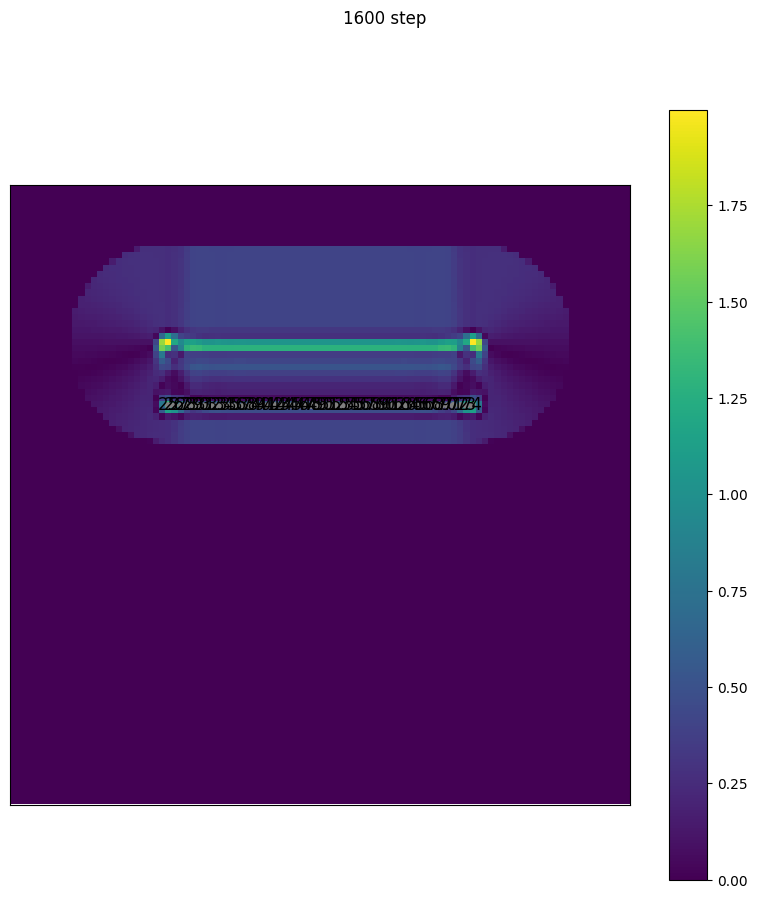

In [21]:
# sadece snake'i kaydırdığımız versiyon
g = nx.Graph()
for i in range(25,75):  # Start from 0
    g.add_node(i, pos=np.array([25, i]))
    if i > 25:
        g.add_edge(i, i - 1)
        
stepsz=0.33
alpha=0
beta=0
crop=[slice(0,200), slice(0,200)]
ndims=2

s=snake.Snake(g,crop,stepsz,alpha,beta,ndims)  

size=[100,100]
cropsz=[16,16]
dmax=16
maxedge=4
 
pred_perfect=s.renderDistanceMap(size,cropsz,dmax,maxedge) 
show(pred_perfect.numpy(),"correct energy image and the ground truth graph",g)
plt.colorbar()

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
#pred_initial2[:,:,33:34,:]=16.0
""" pred_initial3=pred_perfect.clone()[None,None]

pred_initial2[:,:,33:34,:]=16.0
pred_initial3[:,:,33:34,:]=16.0
pred_initial3[:,:,63:64,:]=16.0 """

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2=pred_initial2.clone()
pred2.requires_grad_(True)
""" pred2=pred_initial2.clone()
pred3=pred_initial3.clone()
pred.requires_grad_(True)
pred2.requires_grad_(True)
pred3.requires_grad_(True) """

# predf = (pred+pred2+pred3)/3
# predf.requires_grad_(True)
# perturb the ground truth graph
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([10,0]) 

show(pred_initial[0][0].detach().numpy(),"initial (perturbed) energy image and the perturbed graph",g)
plt.colorbar()

fltrstdev=1.0

#opt = optim.SGD([pred,pred2,pred3], lr=5.0, momentum=0.0)
# pred2 is optimized
opt = optim.SGD([pred2], lr=5.0, momentum=0.0)


extgradfac=1.0
nsteps=20

loss=Loss_MSE_GaussSnake_wGrad3(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                cropsz,dmax,maxedge,extgradfac)

# 2000'e artırdım, çünkü daha baştaki 200 iyi sonuç vermiyordu
# iyi sonuç vermemsinin sebebi de tek predication kullanmam
# normalde neden 3 predictionu aynı anda kullanıyorduk?
for i in range(2000):
    opt.zero_grad()
    t = time.time()
    #l=loss.forward(th.stack((pred,pred2,pred3),axis=0),[g])
    l = loss.forward(pred2, [g], i)
    # this calculates the backward for the loss to change pred2
    l.backward()
    # optimization is done on pred2
    opt.step()
    if i % 400 == 0:
        show(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),str(i)+" step",g)
        plt.colorbar()


""" show(pred[0][0].detach().numpy(),"learnt energy image")
plt.colorbar()
show(th.abs(pred-pred_initial)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar() """

show(pred2[0][0].detach().numpy(),"learnt energy image2")
plt.colorbar()
show(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar()

""" show(pred3[0][0].detach().numpy(),"learnt energy image3")
plt.colorbar()
show(th.abs(pred3-pred_initial3)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar() """

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show(pred_initial[0][0].numpy(),"initial energy image and the last snake",
     loss.snake.getGraph())
plt.colorbar()

show(final_pred[0][0].numpy(),"learnt energy image and the last snake", loss.snake.getGraph())
plt.colorbar()

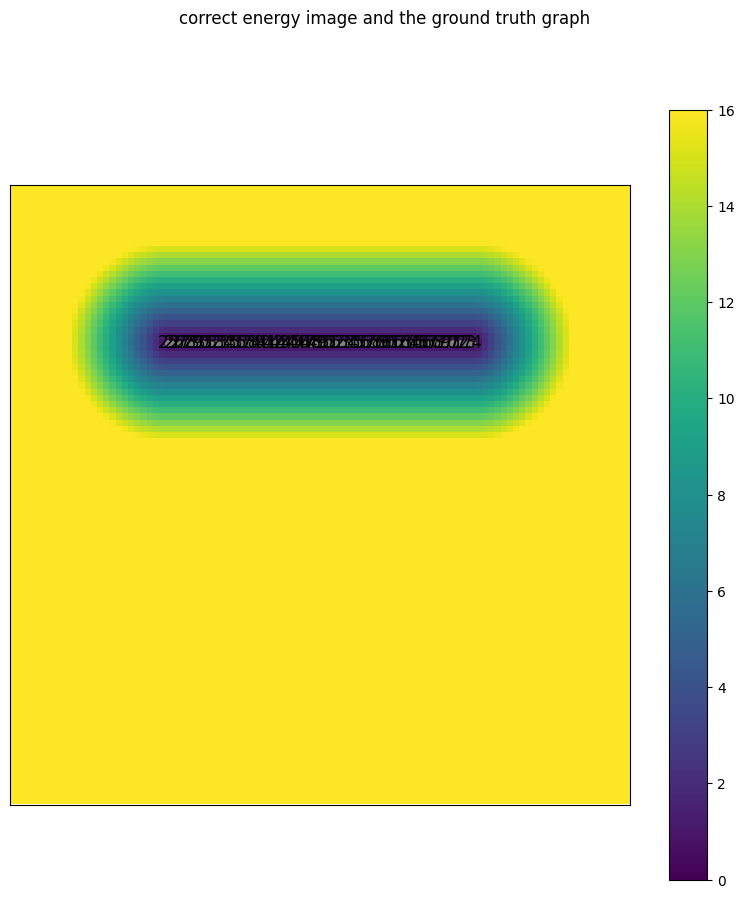

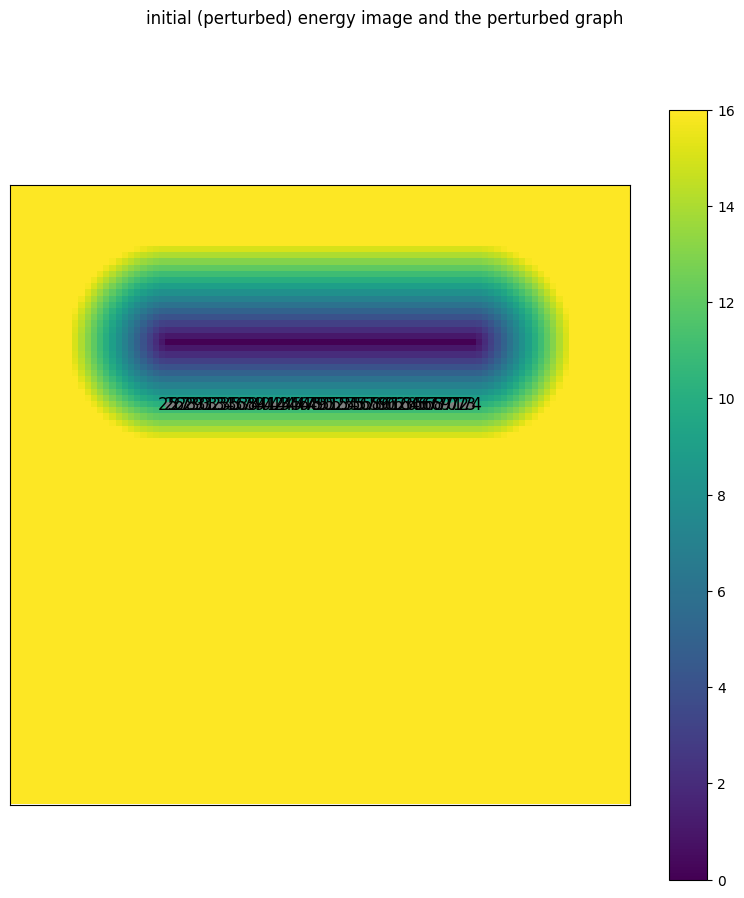

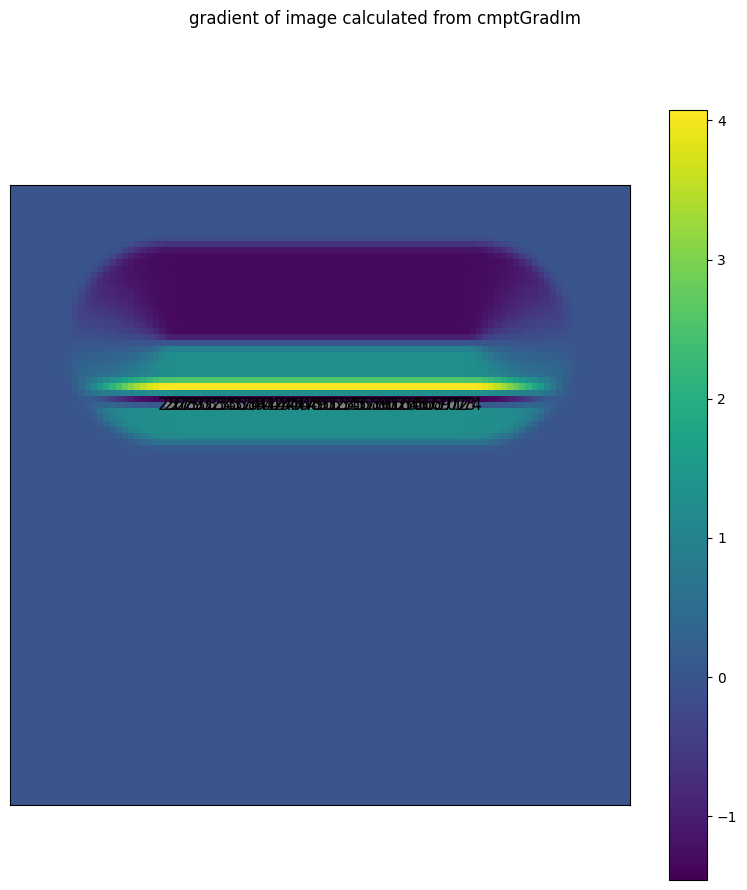

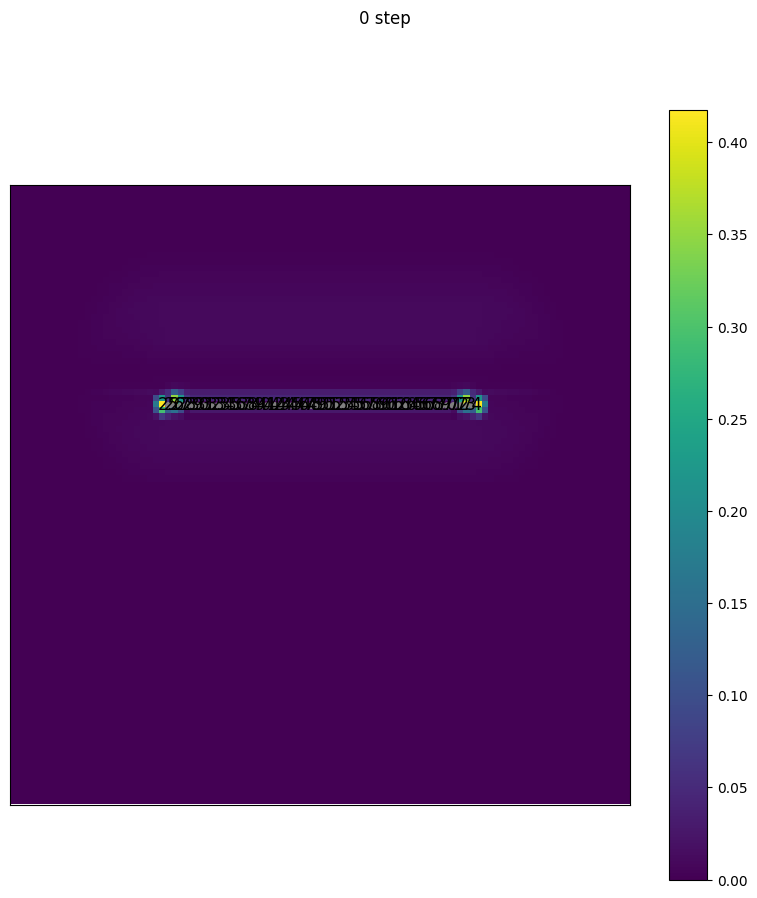

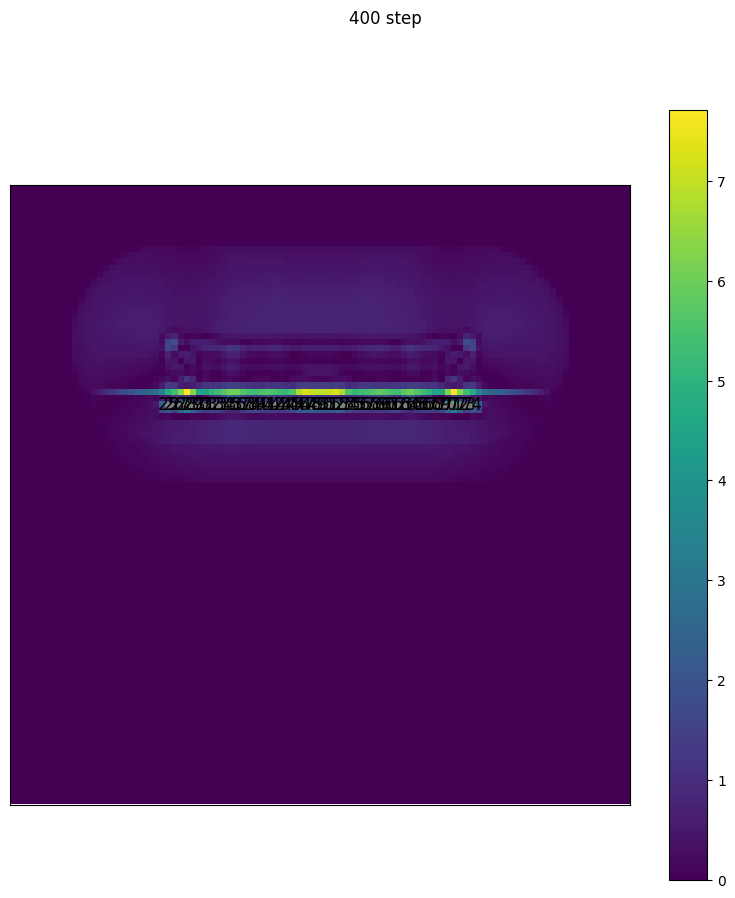

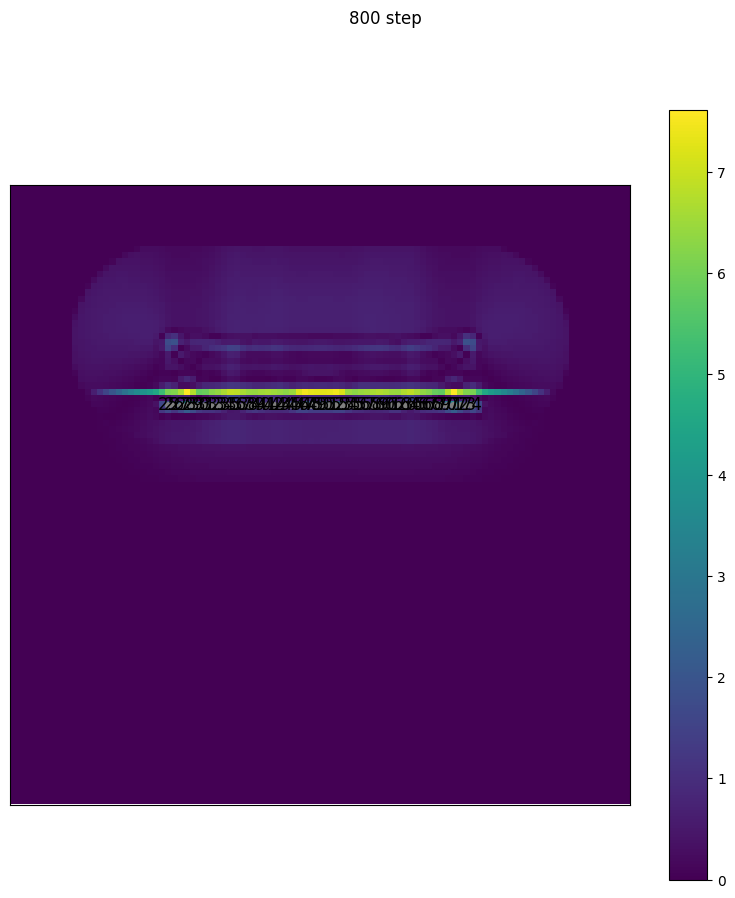

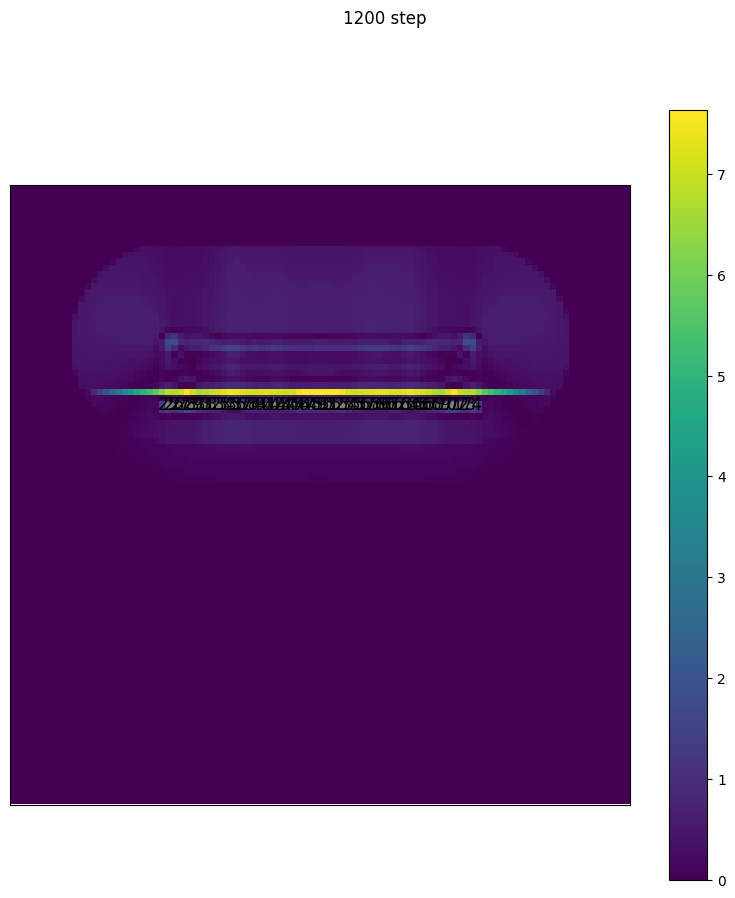

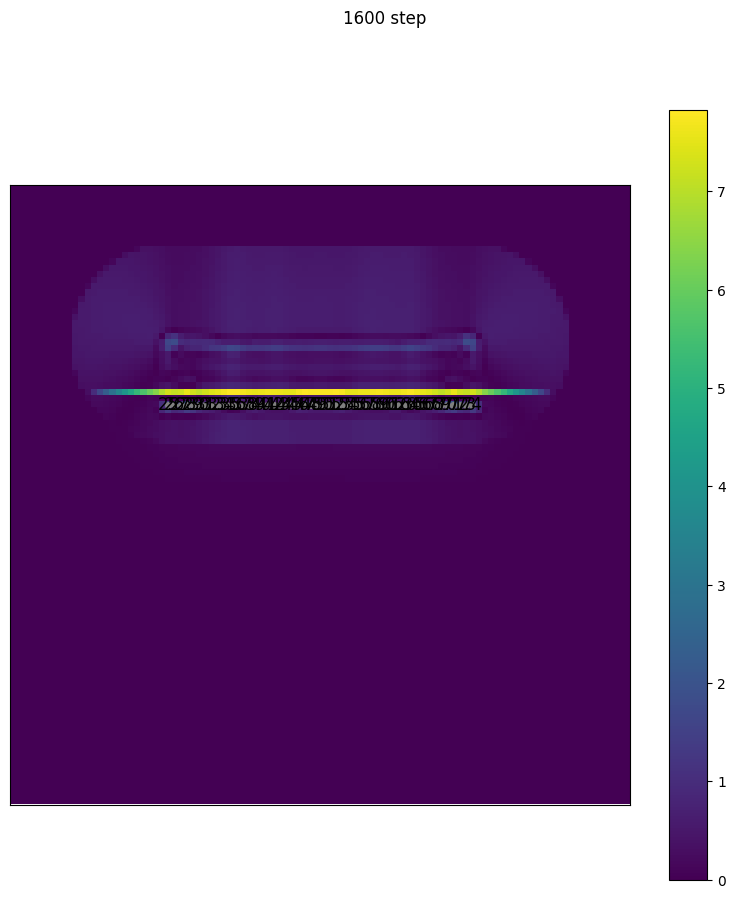

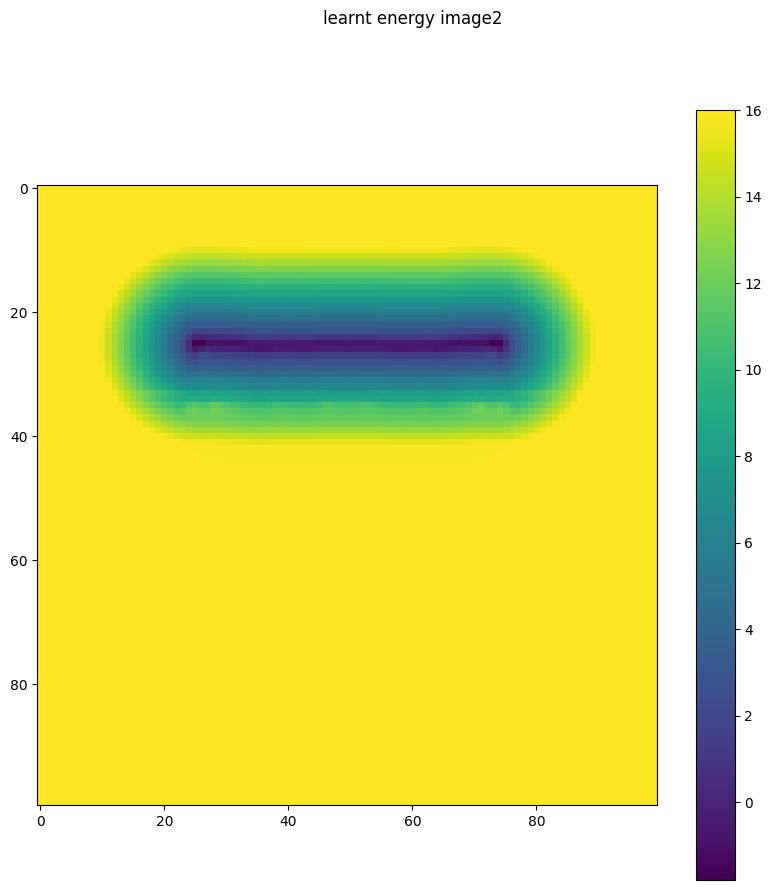

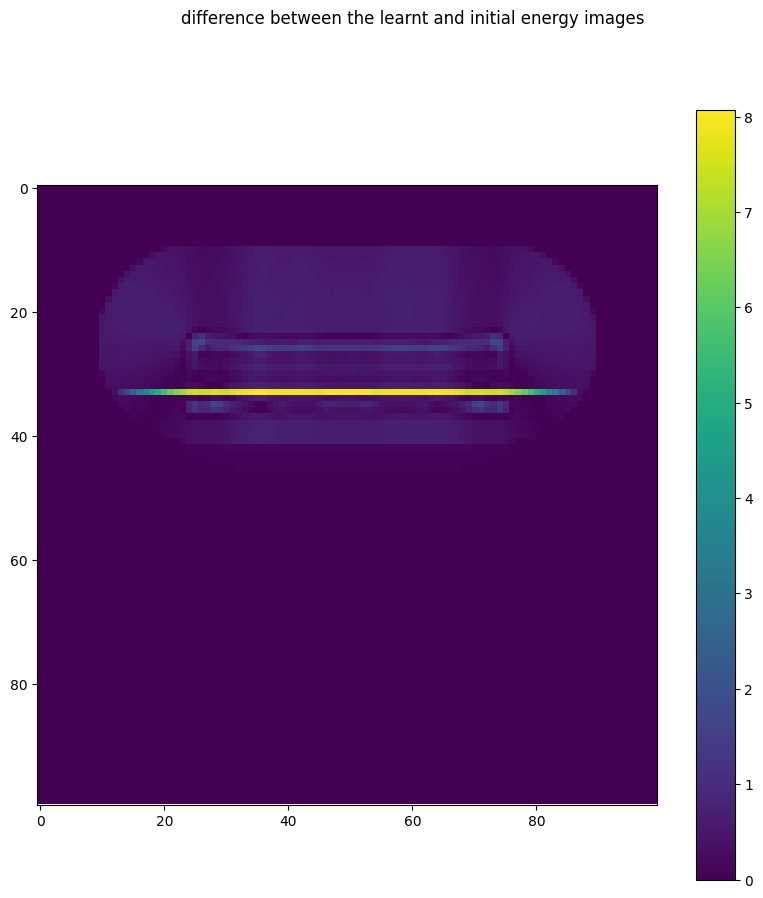

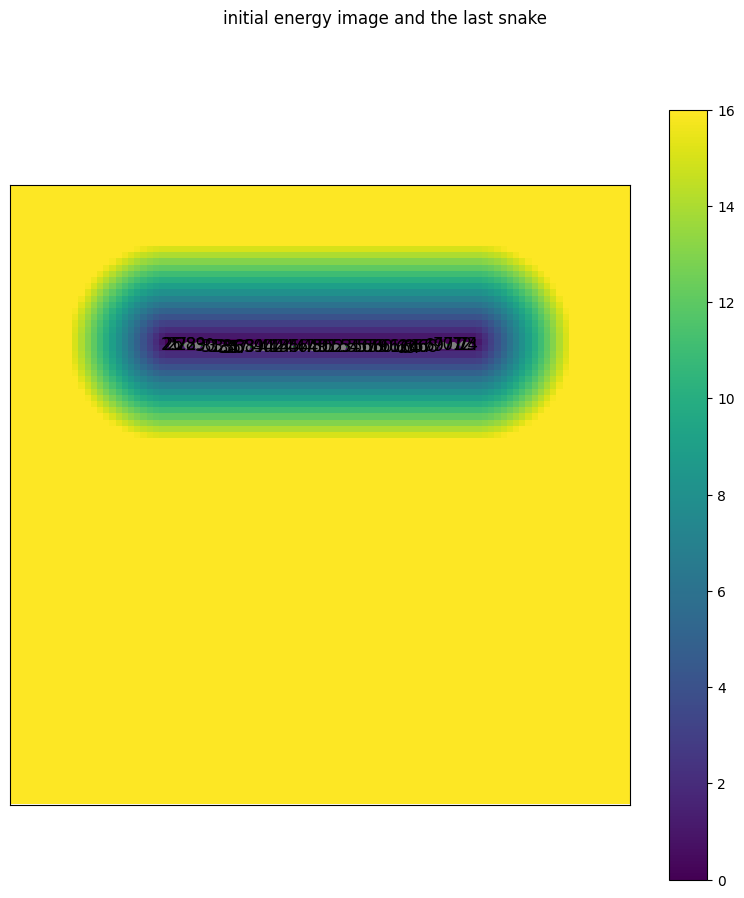

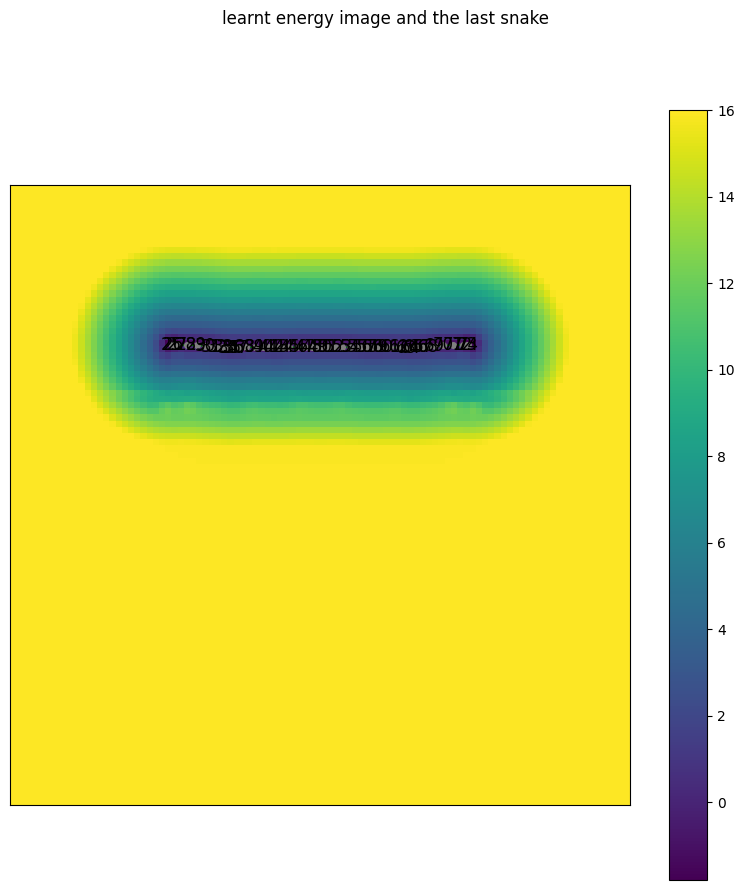

In [57]:
#hem snake'i kaydırdığımızı hem de predictionu bozduğumuz versiyon
g = nx.Graph()
for i in range(25,75):  # Start from 0
    g.add_node(i, pos=np.array([25, i]))
    if i > 25:
        g.add_edge(i, i - 1)
        
stepsz=0.33
alpha=0
beta=0
crop=[slice(0,200), slice(0,200)]
ndims=2

s=snake.Snake(g,crop,stepsz,alpha,beta,ndims)  

size=[100,100]
cropsz=[16,16]
dmax=16
maxedge=4
 
pred_perfect=s.renderDistanceMap(size,cropsz,dmax,maxedge) 
show(pred_perfect.numpy(),"correct energy image and the ground truth graph",g)
plt.colorbar()

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
pred_initial2[:,:,33:34,:]=16.0
""" pred_initial3=pred_perfect.clone()[None,None]

pred_initial2[:,:,33:34,:]=16.0
pred_initial3[:,:,33:34,:]=16.0
pred_initial3[:,:,63:64,:]=16.0 """

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2=pred_initial2.clone()
pred2.requires_grad_(True)
""" pred2=pred_initial2.clone()
pred3=pred_initial3.clone()
pred.requires_grad_(True)
pred2.requires_grad_(True)
pred3.requires_grad_(True) """

# predf = (pred+pred2+pred3)/3
# predf.requires_grad_(True)
# perturb the ground truth graph
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([10,0]) 

show(pred_initial[0][0].detach().numpy(),"initial (perturbed) energy image and the perturbed graph",g)
plt.colorbar()

fltrstdev=1.0

#opt = optim.SGD([pred,pred2,pred3], lr=5.0, momentum=0.0)
# pred2 is optimized
opt = optim.SGD([pred2], lr=5.0, momentum=0.0)


extgradfac=1.0
nsteps=20

loss=Loss_MSE_GaussSnake_wGrad3(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                cropsz,dmax,maxedge,extgradfac)

# 2000'e artırdım, çünkü daha baştaki 200 iyi sonuç vermiyordu
# iyi sonuç vermemsinin sebebi de tek predication kullanmam
# normalde neden 3 predictionu aynı anda kullanıyorduk?
for i in range(2000):
    opt.zero_grad()
    t = time.time()
    #l=loss.forward(th.stack((pred,pred2,pred3),axis=0),[g])
    l = loss.forward(pred2, [g], i)
    # this calculates the backward for the loss to change pred2
    l.backward()
    # optimization is done on pred2
    opt.step()
    if i % 400 == 0:
        show(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),str(i)+" step",g)
        plt.colorbar()


""" show(pred[0][0].detach().numpy(),"learnt energy image")
plt.colorbar()
show(th.abs(pred-pred_initial)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar() """

show(pred2[0][0].detach().numpy(),"learnt energy image2")
plt.colorbar()
show(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar()

""" show(pred3[0][0].detach().numpy(),"learnt energy image3")
plt.colorbar()
show(th.abs(pred3-pred_initial3)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar() """

final_pred=pred2.detach()
show(pred_initial[0][0].numpy(),"initial energy image and the last snake",
     loss.snake.getGraph())
plt.colorbar()

show(final_pred[0][0].numpy(),"learnt energy image and the last snake", loss.snake.getGraph())
plt.colorbar()

1 <class 'list'>
1 <class 'torch.Tensor'>
1


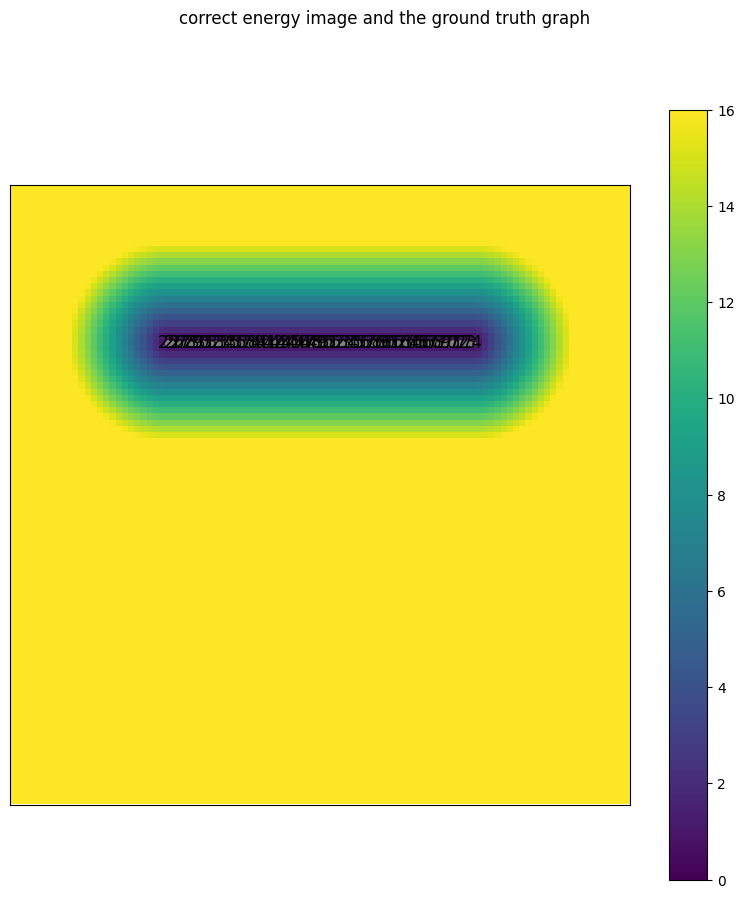

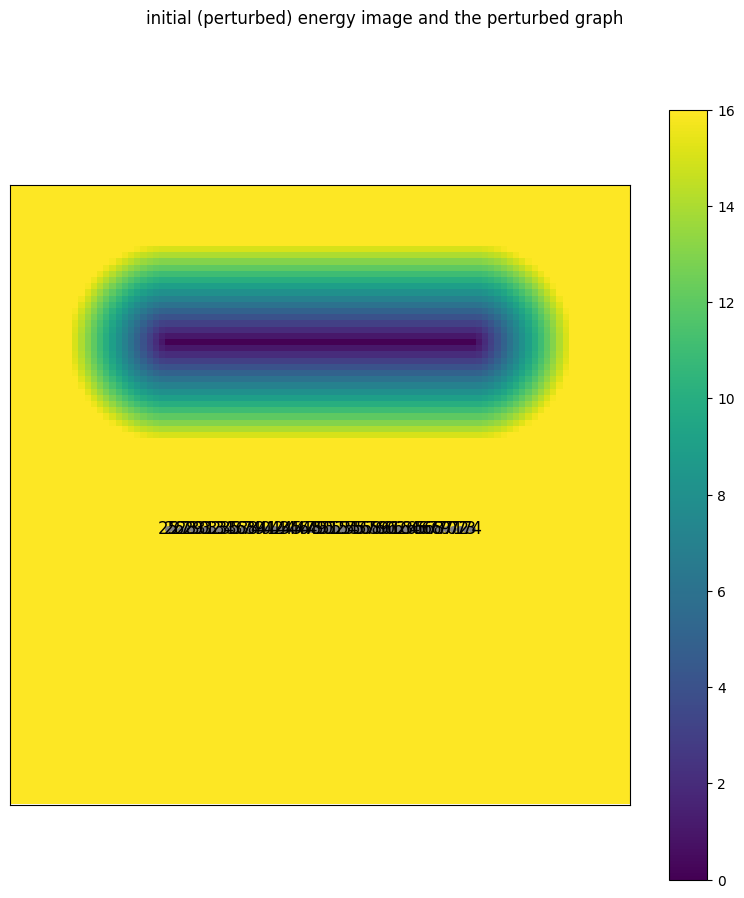

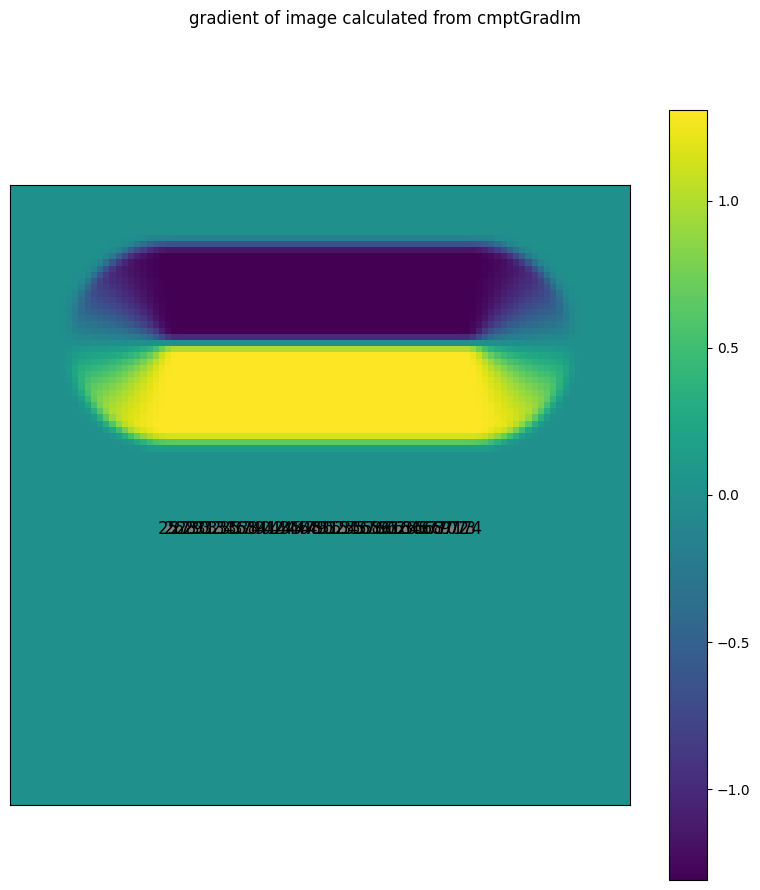

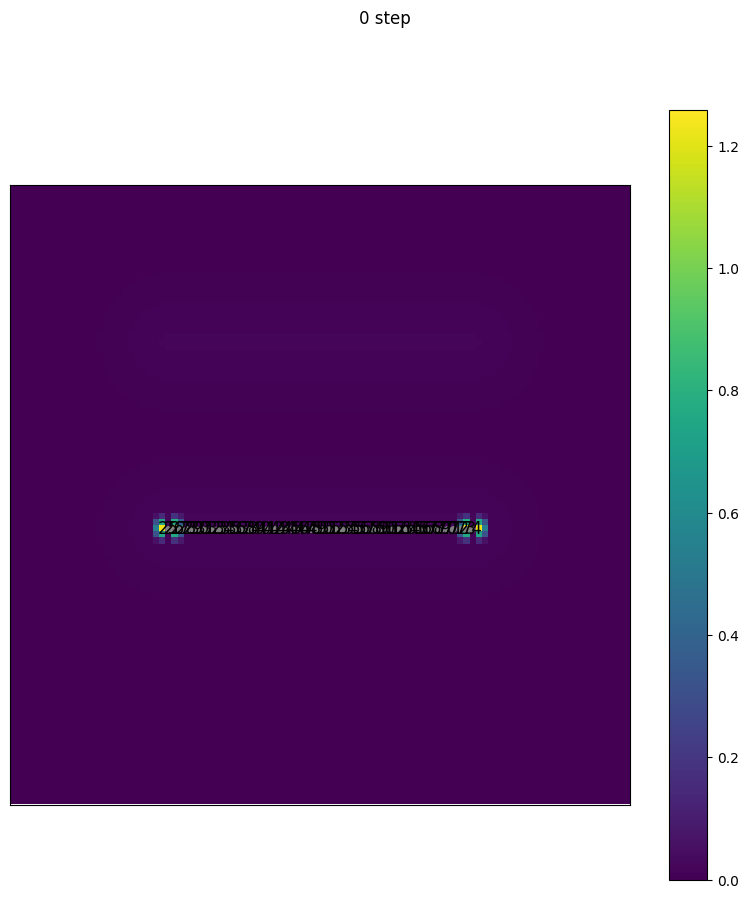

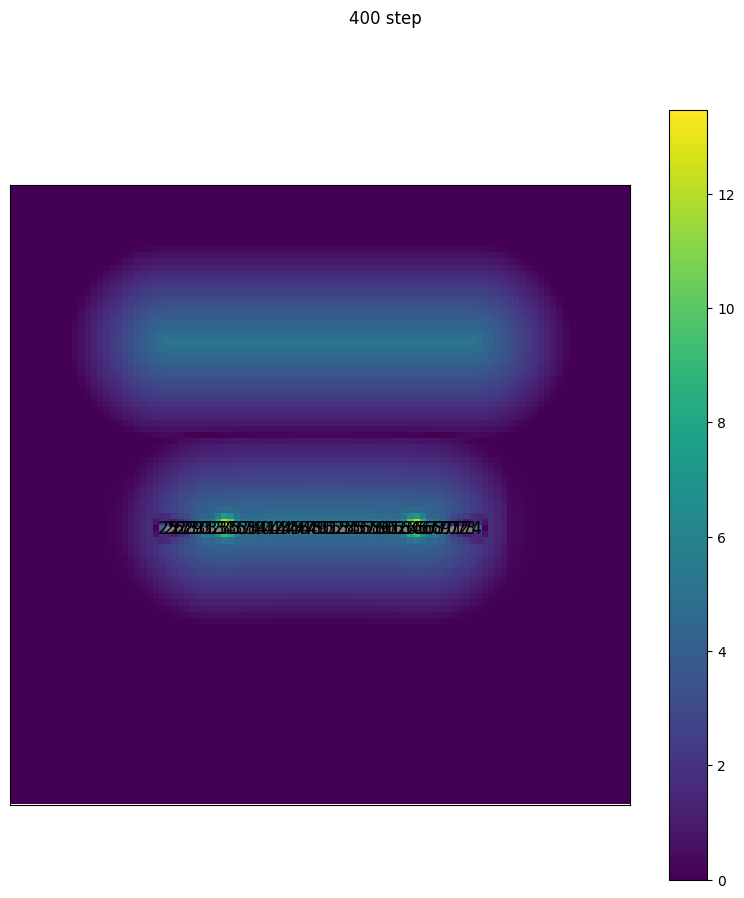

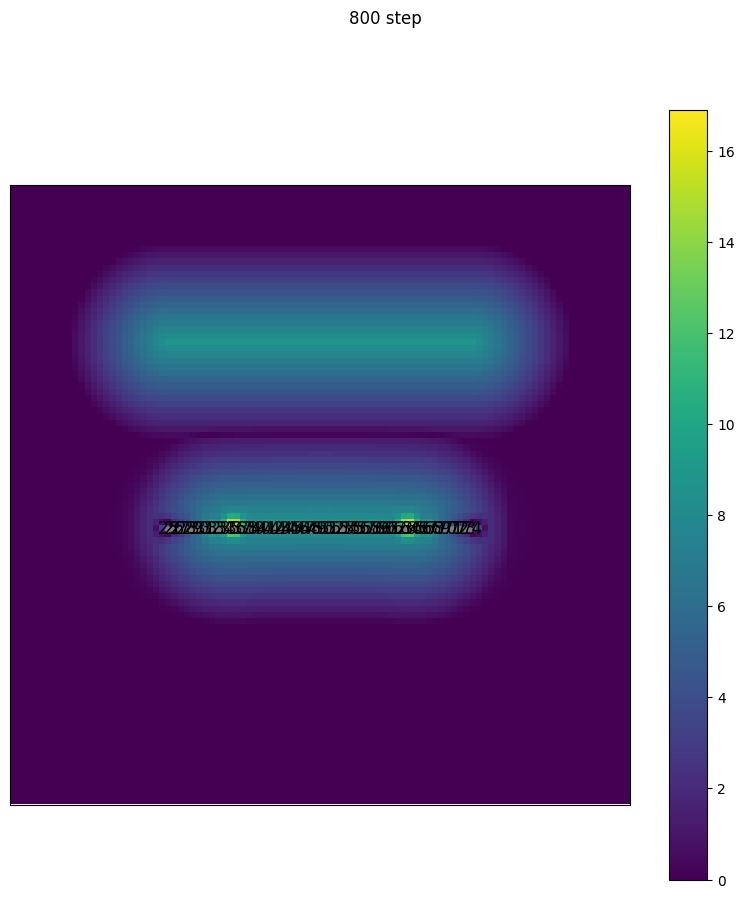

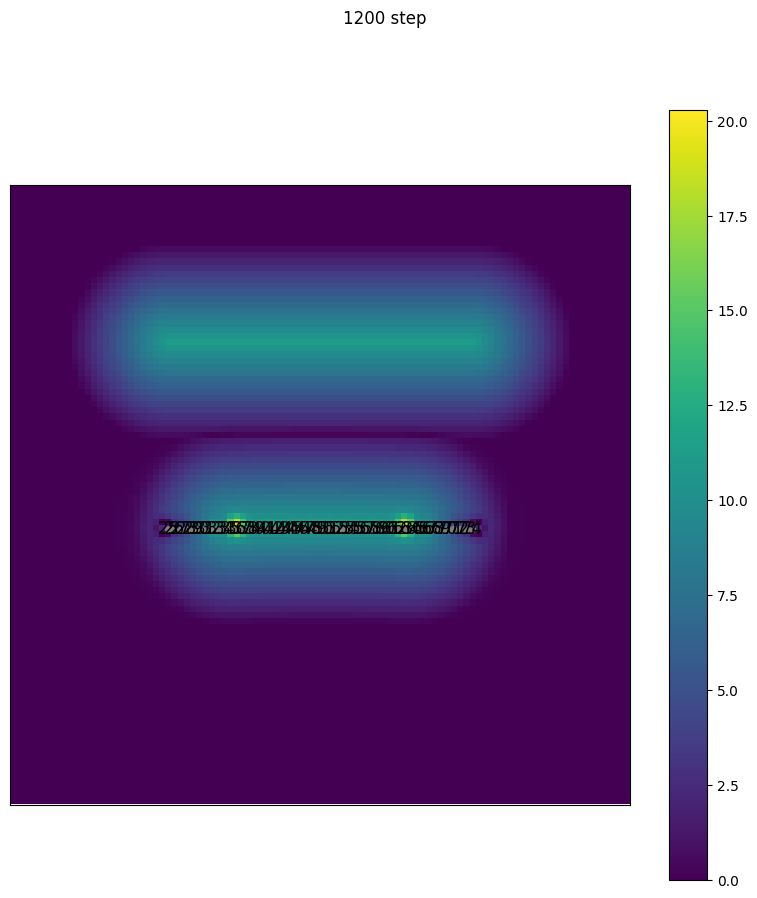

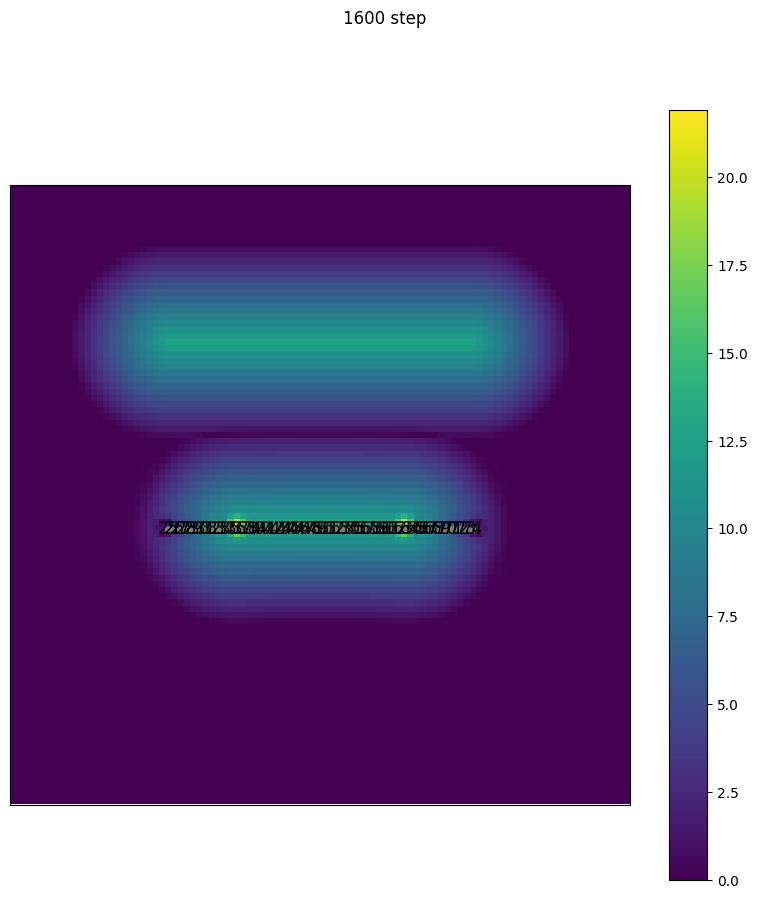

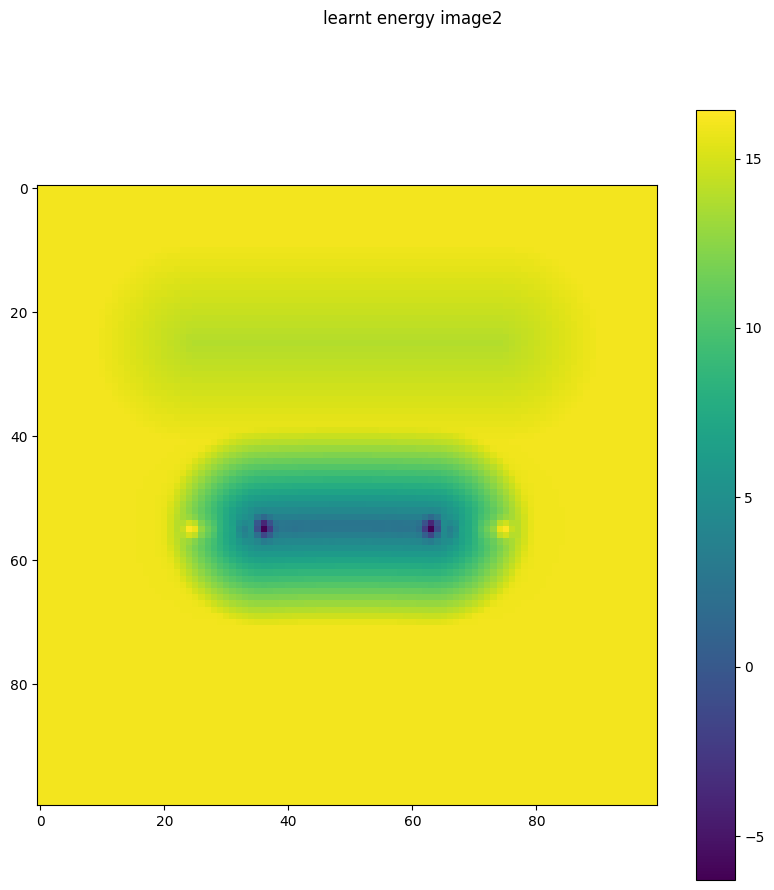

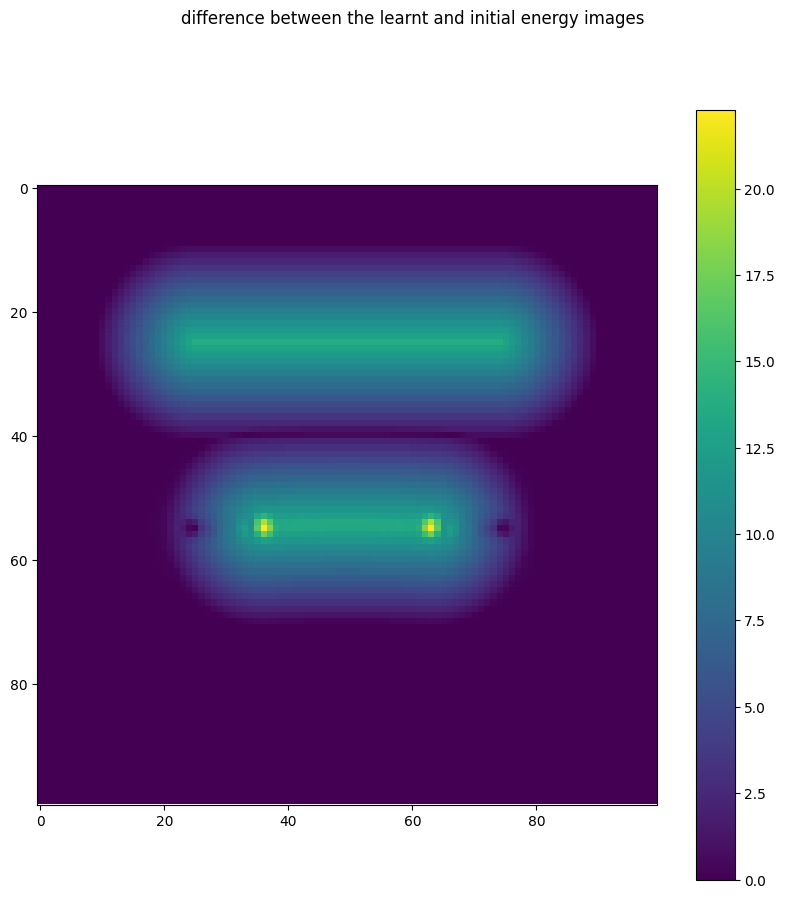

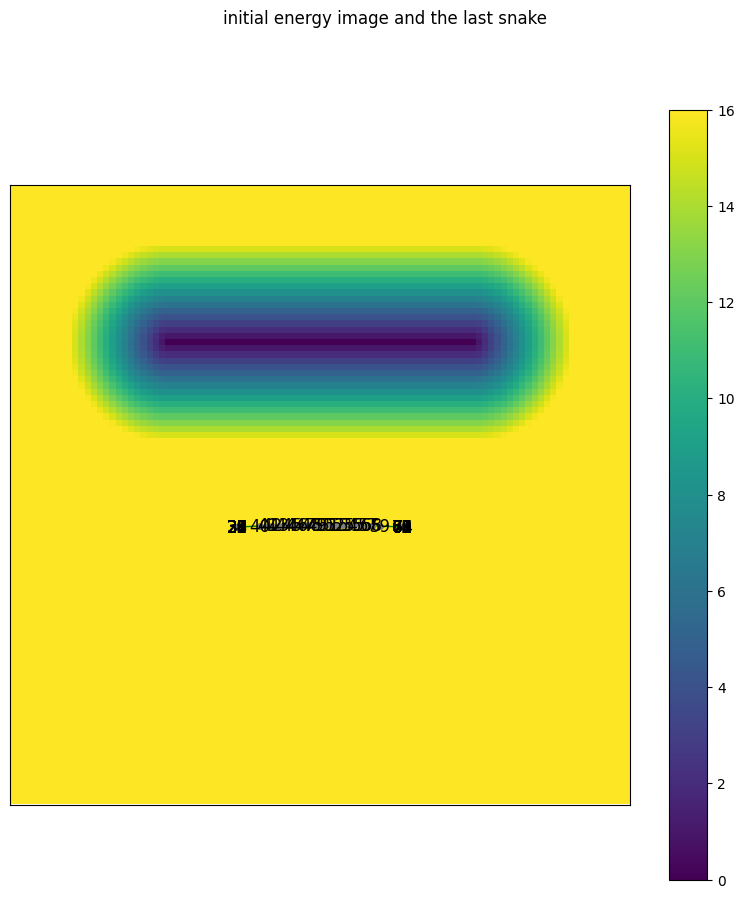

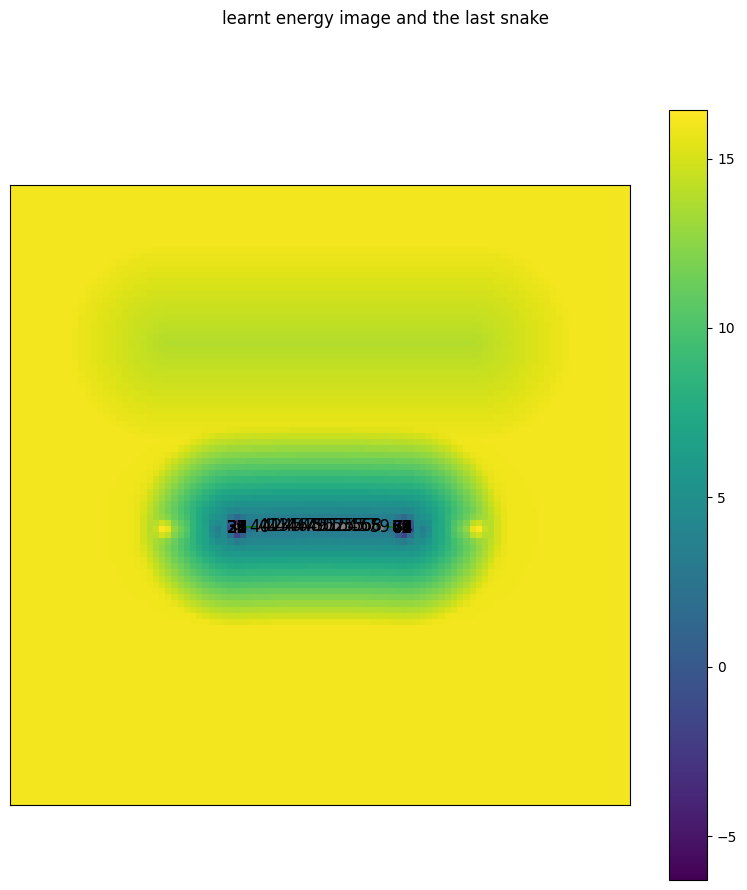

In [60]:
# sadece snake'i çok uzağa kaydırdığımız versiyon
g = nx.Graph()
for i in range(25,75):  # Start from 0
    g.add_node(i, pos=np.array([25, i]))
    if i > 25:
        g.add_edge(i, i - 1)
        
stepsz=0.33
alpha=0
beta=0
crop=[slice(0,200), slice(0,200)]
ndims=2

s=snake.Snake(g,crop,stepsz,alpha,beta,ndims)  

size=[100,100]
cropsz=[16,16]
dmax=16
maxedge=4
 
pred_perfect=s.renderDistanceMap(size,cropsz,dmax,maxedge) 
show(pred_perfect.numpy(),"correct energy image and the ground truth graph",g)
plt.colorbar()

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
#pred_initial2[:,:,33:34,:]=16.0
""" pred_initial3=pred_perfect.clone()[None,None]

pred_initial2[:,:,33:34,:]=16.0
pred_initial3[:,:,33:34,:]=16.0
pred_initial3[:,:,63:64,:]=16.0 """

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2=pred_initial2.clone()
pred2.requires_grad_(True)
""" pred2=pred_initial2.clone()
pred3=pred_initial3.clone()
pred.requires_grad_(True)
pred2.requires_grad_(True)
pred3.requires_grad_(True) """

# predf = (pred+pred2+pred3)/3
# predf.requires_grad_(True)
# perturb the ground truth graph
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([30,0]) 

show(pred_initial[0][0].detach().numpy(),"initial (perturbed) energy image and the perturbed graph",g)
plt.colorbar()

fltrstdev=1.0

#opt = optim.SGD([pred,pred2,pred3], lr=5.0, momentum=0.0)
# pred2 is optimized
opt = optim.SGD([pred2], lr=5.0, momentum=0.0)


extgradfac=1.0
nsteps=20

loss=Loss_MSE_GaussSnake_wGrad3(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                cropsz,dmax,maxedge,extgradfac)

# 2000'e artırdım, çünkü daha baştaki 200 iyi sonuç vermiyordu
# iyi sonuç vermemsinin sebebi de tek predication kullanmam
# normalde neden 3 predictionu aynı anda kullanıyorduk?
for i in range(2000):
    opt.zero_grad()
    t = time.time()
    #l=loss.forward(th.stack((pred,pred2,pred3),axis=0),[g])
    l = loss.forward(pred2, [g], i)
    # this calculates the backward for the loss to change pred2
    l.backward()
    # optimization is done on pred2
    opt.step()
    if i % 400 == 0:
        show(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),str(i)+" step",g)
        plt.colorbar()


""" show(pred[0][0].detach().numpy(),"learnt energy image")
plt.colorbar()
show(th.abs(pred-pred_initial)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar() """

show(pred2[0][0].detach().numpy(),"learnt energy image2")
plt.colorbar()
show(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar()

""" show(pred3[0][0].detach().numpy(),"learnt energy image3")
plt.colorbar()
show(th.abs(pred3-pred_initial3)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar() """

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show(pred_initial[0][0].numpy(),"initial energy image and the last snake",
     loss.snake.getGraph())
plt.colorbar()

show(final_pred[0][0].numpy(),"learnt energy image and the last snake", loss.snake.getGraph())
plt.colorbar()

# Ribon Snake Trials

In [38]:
from Codes.Losses.snake import Snake
import torch
from torch import nn
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt as dist
from Codes.Losses.renderDistanceMap import getCropCoords
from Codes.Losses.renderLineGraph import drawLine
from functools import reduce

# Gaussian gradient for snakes

def makeGaussEdgeFltr(stdev,d):
    # make a Gaussian-derivative-based edge filter
    # filter size is determined automatically based on stdev
    # the filter is ready to be used with pytorch conv 
    # input params:
    #   stdev - the standard deviation of the Gaussian
    #   d - number of dimensions
    # output:
    #   fltr, a np.array of size d X 1 X k X k,
    #         where k is an odd number close to 4*stdev
    #         fltr[i] contains a filter sensitive to gradients
    #         along the i-th dimension

    fsz=round(2*stdev)*2+1 # filter size - make the it odd

    n=np.arange(0,fsz).astype(np.float)-(fsz-1)/2.0
    s2=stdev*stdev
    v=np.exp(-n**2/(2*s2)) # a Gaussian
    g=n/s2*v # negative Gaussian derivative

    # create filter sensitive to edges along dim0
    # by outer product of vectors
    shps = np.eye(d,dtype=np.int)*(fsz-1)+1
    reshaped = [x.reshape(y) for x,y in zip([g]+[v]*(d-1), shps)]
    fltr=reduce(np.multiply,reshaped)
    fltr=fltr/np.sum(np.abs(fltr))
    
    # add the out_channel, in_channel initial dimensions
    fltr_=fltr[np.newaxis,np.newaxis]
    # transpose the filter to be sensitive to edges in all directions 
    fltr_multidir=np.concatenate([np.moveaxis(fltr_,2,k) for k in range(2,2+d)],axis=0)
    
    return fltr_multidir

def cmptGradIm(img,fltr):
    # convolves img with fltr, with replication padding
    # fltr is assumed to be of odd size
    # img  is either 2D: batch X channel X height X width
    #             or 3D: batch X channel X height X width X depth
    #      it is a torch tensor
    # fltr is either 2D: 2 X 1 X k X k
    #             or 3D: 3 X 1 X k X k X k
    #      it is a torch tensor
    # creates 
    
    if img.dim()==4:
        img_p=torch.nn.ReplicationPad2d(fltr.shape[2]//2).forward(img)
        return torch.nn.functional.conv2d(img_p,fltr)
    if img.dim()==5:
        img_p=torch.nn.ReplicationPad3d(fltr.shape[2]//2).forward(img)
        return torch.nn.functional.conv3d(img_p,fltr)
    else:
        raise ValueError("img should have 4 or 5 dimensions")

def cmptExtGrad(snakepos,eGradIm):
    # returns the values of eGradIm at positions snakepos
    # snakepos  is a k X d matrix, where snakepos[j,:] represents a d-dimensional position of the j-th node of the snake
    # eGradIm   is a tensor containing the energy gradient image, either of size
    #           3 X d X h X w, for 3D, or of size
    #           2     X h X w, for 2D snakes
    # returns a tensor of the same size as snakepos,
    # containing the values of eGradIm at coordinates specified by snakepos
    
    # scale snake coordinates to match the hilarious requirements of grid_sample
    # we use the obsolote convention, where align_corners=True
    scale=torch.tensor(eGradIm.shape[1:]).reshape((1,-1)).type_as(snakepos)-1.0
    sp=2*snakepos/scale-1.0
    
    if eGradIm.shape[0]==3:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('km,md->kd',[sp,torch.tensor([[0,0,1],[0,1,0],[1,0,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,4,1)
    if eGradIm.shape[0]==2:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('kl,ld->kd',[sp,torch.tensor([[0,1],[1,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,1)
        
    return egrad.reshape_as(snakepos)


class Ribbon_Snake(Snake):
# represents a class that is similar to snake but also contains width information
# the width information can be represented by sampling along the nodes of the snake and
# attaching width information to the samples
# each width will try to minimize a energy
# the energy they will try to minimize will try to fit the width to the edge of the distance map
# will try different values to fit the
#### Assumptions
# the shape of the 3d structure is tought of as a cylinder that is a perfect circle
# this can be changed to aa elypse like structure too, but not implemented yet 
    def __init__(self,graph,crop,stepsz,alpha,beta,ndims, num_samples=10):
    # added a way to select how many samples to take between each control point
    # for each sample we keep its width info
    # at the start all of the sample are set to width 1
        super(Ribbon_Snake,self).__init__(graph,crop,stepsz,alpha,beta,ndims)
        self.num_samples = num_samples
        self.samples = self.create_samples()
        self.widths = np.ones((len(self.samples),))
        self.iscuda = False

    def cuda(self):
        super(Ribbon_Snake, self).cuda()
        self.iscuda = True

    def create_samples(self):
    # we look for the each edge of the graph
    # then we sample the points between in equal intervals
    # return their possitions
        samples = []
        for u, v in self.h.edges:
            pos_u = self.h.nodes[u]["pos"]
            pos_v = self.h.nodes[v]["pos"]
            for t in np.linspace(0, 1, self.num_samples, endpoint=False):
                sample_pos = (1 - t) * pos_u + t * pos_v
                samples.append(sample_pos)
        return np.array(samples)
    
    def set_widths(self, widths):
    # may need more complicated way to set the widths
        self.widths = widths

    def get_samples_with_widths(self):
    # returns the samples along with their widths
        return list(zip(self.samples, self.widths))
    
    def render_width_map(self, size, cropsz, dmax, maxedgelen):
    # this tries to create a map that represents the ribbon snake
    # the parts in the map belonging to the snake will be 1 and others 0
    # centerline will be determines by the node locations
    # and the width will be determine by the sample's width info
    # we will try to create a cylinder from the cetnerline and sample width information
    # inside the cylinder will be set to 1s
    ## this will be used in the loss function to measure models performance in
    # predicting the overall width and centerline info
        width_map = np.zeros(size, dtype=np.float32)

        samples_with_widths = self.get_samples_with_widths()
        num_samples = len(samples_with_widths)

        for i in range(num_samples):
            sample, width = samples_with_widths[i]
            center_x, center_y = int(round(sample[0])), int(round(sample[1]))
            radius = int(np.ceil(width / 2))

            # Draw a filled circle (approximation of the width at the sample point)
            for y in range(max(0, center_y - radius), min(size[1], center_y + radius + 1)):
                for x in range(max(0, center_x - radius), min(size[0], center_x + radius + 1)):
                    if (x - center_x)**2 + (y - center_y)**2 <= radius**2:
                        width_map[x, y] = 1.0

            # Connect consecutive samples with filled areas
            if i < num_samples - 1:
                next_sample, _ = samples_with_widths[i + 1]
                next_center_x, next_center_y = int(round(next_sample[0])), int(round(next_sample[1]))
                current_radius = int(np.ceil(width / 2))
                next_radius = int(np.ceil(samples_with_widths[i+1][1] / 2))

                # Approximate the connecting area by filling between the circles

                # Find the min and max x and y coordinates to bound the area
                min_x = min(center_x - current_radius, next_center_x - next_radius)
                max_x = max(center_x + current_radius, next_center_x + next_radius)
                min_y = min(center_y - current_radius, next_center_y - next_radius)
                max_y = max(center_y + current_radius, next_center_y + next_radius)

                for y in range(max(0, min_y), min(size[1], max_y + 1)):
                    for x in range(max(0, min_x), min(size[0], max_x + 1)):
                        # Check if the point lies roughly within the connecting area
                        # This is a simplified approximation. A more accurate approach would involve
                        # calculating the distance to the line segment and comparing to the width.

                        # Check if the point is within the bounding box of the two circles
                        is_in_current_circle = (x - center_x)**2 + (y - center_y)**2 <= current_radius**2
                        is_in_next_circle = (x - next_center_x)**2 + (y - next_center_y)**2 <= next_radius**2

                        if is_in_current_circle or is_in_next_circle:
                            width_map[x, y] = 1.0
                        else:
                            # Approximate if the point is between the two circles
                            # Check if x is between the x-coordinates of the centers
                            if min(center_x, next_center_x) <= x <= max(center_x, next_center_x):
                                # A simple linear interpolation of the radius
                                alpha = abs(x - center_x) / abs(next_center_x - center_x + 1e-8) # Avoid division by zero
                                interpolated_radius = current_radius * (1 - alpha) + next_radius * alpha
                                center_y_interpolated = int(round(center_y * (1 - alpha) + next_center_y * alpha))
                                if abs(y - center_y_interpolated) <= interpolated_radius:
                                    width_map[x, y] = 1.0
                            elif min(center_y, next_center_y) <= y <= max(center_y, next_center_y):
                                alpha = abs(y - center_y) / abs(next_center_y - center_y + 1e-8)
                                interpolated_radius = current_radius * (1 - alpha) + next_radius * alpha
                                center_x_interpolated = int(round(center_x * (1 - alpha) + next_center_x * alpha))
                                if abs(x - center_x_interpolated) <= interpolated_radius:
                                    width_map[x, y] = 1.0

        return torch.from_numpy(width_map).float().cuda() if self.iscuda else torch.from_numpy(width_map).float()
    

class GradImSnake(Ribbon_Snake):
    # a snake with external energy gradients sampled from a "gradient image"
    
    def __init__(self,graph,crop,stepsz,alpha,beta,ndims,gimg):
        # gimg is the "gradient image"
        # a tensor of size ndim X h X w for 2D snake, or ndim X d X h X w, for 3D
        # gimg[i,h,w] contains the gradient of the external energy
        # with respect to the i-th coordinate of a control point located at (h,w)
        super(GradImSnake,self).__init__(graph,crop,stepsz,alpha,beta,ndims)
        self.gimg=gimg
        self.iscuda=False
    
    def cuda(self):
        super(GradImSnake,self).cuda()
        if self.gimg is not None:
            self.gimg=self.gimg.cuda()
        
    def step(self):
        # external gradient for each control point is extracted from gimg
        return super(GradImSnake,self).step(cmptExtGrad(self.s,self.gimg))
    
    def optim(self,niter):
        # update the snake niter times
        if len(self.s) > 0:
            for i in range(niter):
                self.step()
        return self.s


class RibonFastLoss(nn.Module):
    # the main idea for this loss will be to put the width in an optimal place
    # according to the probability map given by the model
    # we will treat the probability with the highest point as the center like normally
    # but we will also treat points above a certain threshold as points inside the
    # linear structure
    # then we will try to set the widths for the samples to align with the probability map's results
    # but we will also try to not make the width too big
    # need to decide how to optimize this
    def __init__(self, stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                       cropsz,dmax,maxedgelen,extgradfac):
        super(RibonFastLoss,self).__init__()
        self.stepsz = stepsz
        self.alpha = alpha
        self.beta = beta
        self.fltrstdev = fltrstdev
        self.ndims = ndims
        self.cropsz = cropsz
        self.dmax = dmax
        self.maxedgelen = maxedgelen
        self.extgradfac = extgradfac
        self.nsteps = nsteps

        self.fltr = makeGaussEdgeFltr(self.fltrstdev,self.ndims)
        self.fltrt = torch.from_numpy(self.fltr).type(torch.float32)

        self.iscuda = False

    def cuda(self):
        super(RibonFastLoss,self).cuda()
        self.fltrt = self.fltrt.cuda()
        self.iscuda = True
        return self

    def forward(self,pred_dmap,lbl_graphs, num, crops=None):
    # how to get the probability map?
    # pred_dmap is the predicted distance map from the UNet
    # lbl_graphs contains graphs each represent a label as a snake (not exactly a snake but a graph which represents a snake) / not snake class
    # crops is a list of slices, each represents the crop area of the corresponding snake

        pred_ = pred_dmap
        gimg = cmptGradIm(pred_,self.fltrt)
        gimg *= self.extgradfac
        snake_dmap = []
        ribbon_probmap = []

        for i,lg in enumerate(zip(lbl_graphs,gimg)):
            # i is index num
            # lg is a tuple of a graph and a gradient image
            l = lg[0] # graph
            g = lg[1] # gradient image

            if crops is not None:
                crop = crops[i]
            else:
                crop=[slice(0,s) for s in g.shape[1:]]
            s = GradImSnake(l,crop,self.stepsz,self.alpha,
                                      self.beta,self.ndims,g)
            #if self.iscuda: s.cuda()

            s.optim(self.nsteps)

            # getting a probability map in some way
            # if pred_map is the distance we can use a sigmoid of sosme sorts to get the probability map
            # but smaller values in distance map needs to have higher probability
            prob_map = torch.sigmoid(-pred_dmap[i])
            samples_with_widths = s.get_samples_with_widths()

            # Calculate widths for each sample
            new_widths = []
            threshold = 0.18  # Define a probability threshold
            for sample, _ in samples_with_widths:
                center_x, center_y = int(round(sample[0])), int(round(sample[1]))
                max_radius = 0
                for r in range(1, min(pred_dmap.shape[-2] // 2, pred_dmap.shape[-1] // 2)): # Limit radius
                    count_inside = 0
                    count_total = 0
                    for angle in range(0, 360, 10):
                        x = int(center_x + r * np.cos(np.radians(angle)))
                        y = int(center_y + r * np.sin(np.radians(angle)))
                        if 0 <= x < pred_dmap.shape[-2] and 0 <= y < pred_dmap.shape[-1]:
                            count_total += 1
                            if prob_map[0, x, y].item() >= threshold:  # Check probability
                                count_inside += 1
                    if count_total > 0 and count_inside / count_total >= 0.9: # Check if most points are inside
                        max_radius = r
                    else:
                        break
                new_widths.append(max_radius * 2) # Diameter as width

            s.set_widths(np.array(new_widths))

            pmap = s.render_width_map(g.shape[1:],self.cropsz,self.dmax,
                                     self.maxedgelen)
            
            ribbon_probmap.append(pmap)

            dmap = s.renderDistanceMap(g.shape[1:],self.cropsz,self.dmax,
                                     self.maxedgelen)
            snake_dmap.append(dmap)
            
            if num % 200 == 0:
                show(pmap.numpy(), "widthmap", lbl_graphs[0])
                plt.colorbar()

        # because of the width information, need an additinal loss to also
        # calculate the loss connected to under or over estimation
        # render another map with width info, from the ribbon snake
        # and also calculate a loss for this
        # this just looks at the distance map
        snake_dm = torch.stack(snake_dmap,0).unsqueeze(1)
        loss = torch.pow(pred_dmap-snake_dm,2).mean()

        ######
        # something like this
        ######
        # width_loss = torch.pow(prob_map-snake_dm,2).mean()
        # loss = loss + width_loss
        # also we can weigh the width loss differently to reduce or increase its effect
        ribbon_pm = torch.stack(ribbon_probmap,0).unsqueeze(1)
        loss += torch.pow(torch.sigmoid(-pred_dmap)-ribbon_pm,2).mean()
        ######
                  
        self.snake = s
        self.gimg = gimg
        
        return loss

In [23]:
%matplotlib inline
import time
from math import sin,pi
from torch import optim
import networkx as nx
import numpy as np
import Codes.Losses.snake as snake
import matplotlib.pyplot as plt

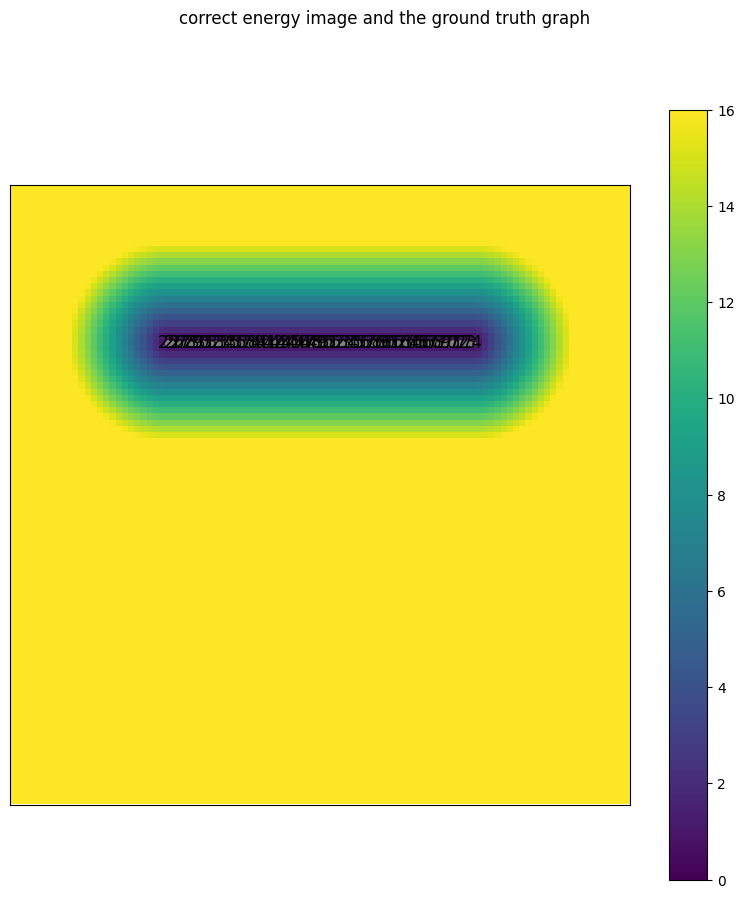

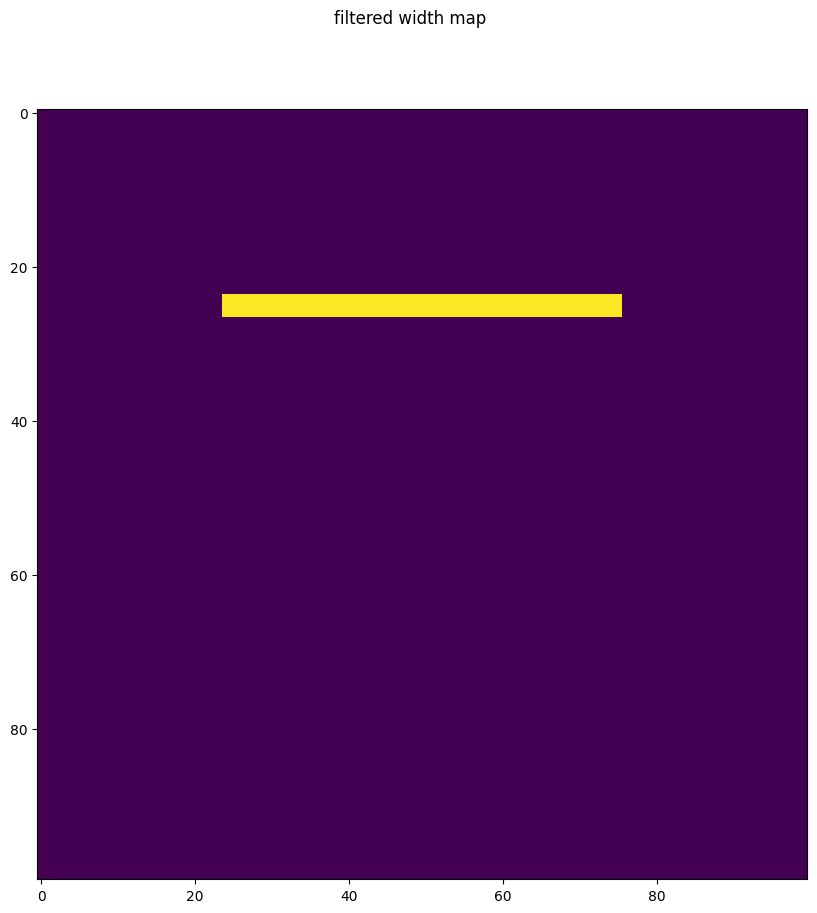

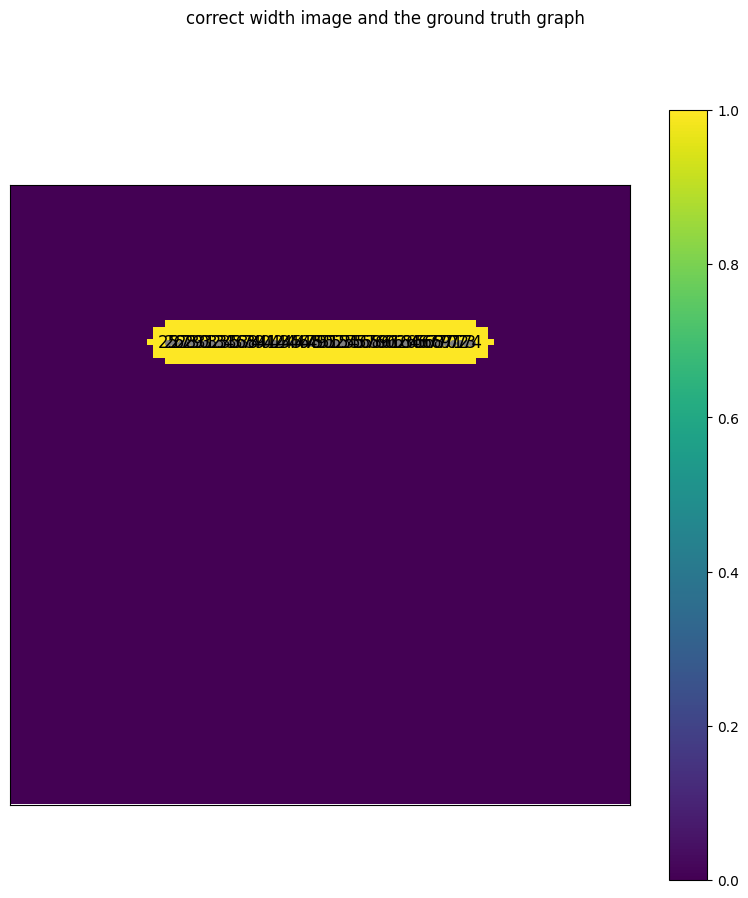

In [39]:
g = nx.Graph()
for i in range(25,75):  # Start from 0
    g.add_node(i, pos=np.array([25, i]))
    if i > 25:
        g.add_edge(i, i - 1)
        
stepsz=0.33
alpha=0
beta=0
crop=[slice(0,200), slice(0,200)]
ndims=2

s=Ribbon_Snake(g,crop,stepsz,alpha,beta,ndims)
sw = s.get_samples_with_widths()
samples, widths = zip(*sw)
widths = np.array(widths)
widths = widths * 5
s.set_widths(widths)

size=[100,100]
cropsz=[16,16]
dmax=16
maxedge=4
 
pred_perfect=s.renderDistanceMap(size,cropsz,dmax,maxedge) 
show(pred_perfect.numpy(),"correct energy image and the ground truth graph",g)
plt.colorbar()

wid_pred = torch.sigmoid(-pred_perfect)
filt_wid = wid_pred > 0.15
show(filt_wid.numpy(), "filtered width map")

pred_dis = s.render_width_map(size, cropsz, dmax, maxedge)
show(pred_dis.numpy(), "correct width image and the ground truth graph", g)
plt.colorbar()

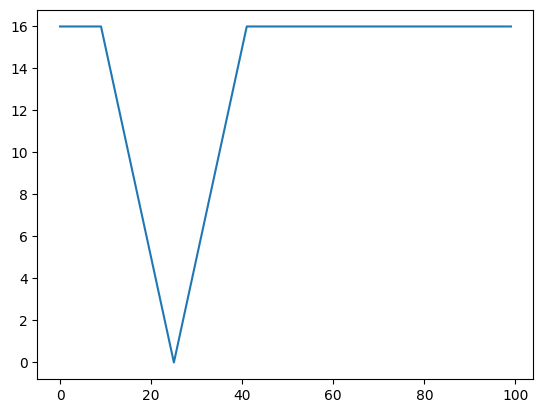

In [41]:
plt.plot(pred_perfect.numpy()[:, 50])

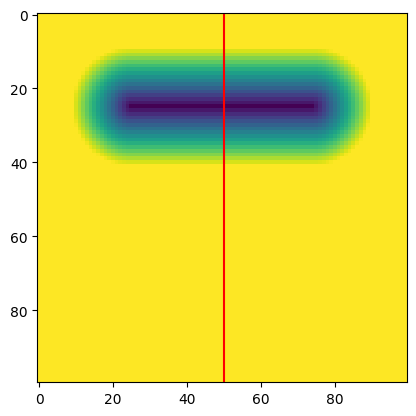

In [43]:
plt.imshow(pred_perfect.numpy())
# draw a vertical red line at the center of the image
plt.axvline(x=50, color='r')

In [35]:
wid_pred.max(), wid_pred.min()

(tensor(0.5000), tensor(1.1254e-07))

C:\Users\serta\AppData\Local\Temp\ipykernel_43796\3373615652.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n=np.arange(0,fsz).astype(np.float)-(fsz-1)/2.0
C:\Users\serta\AppData\Local\Temp\ipykernel_43796\3373615652.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy

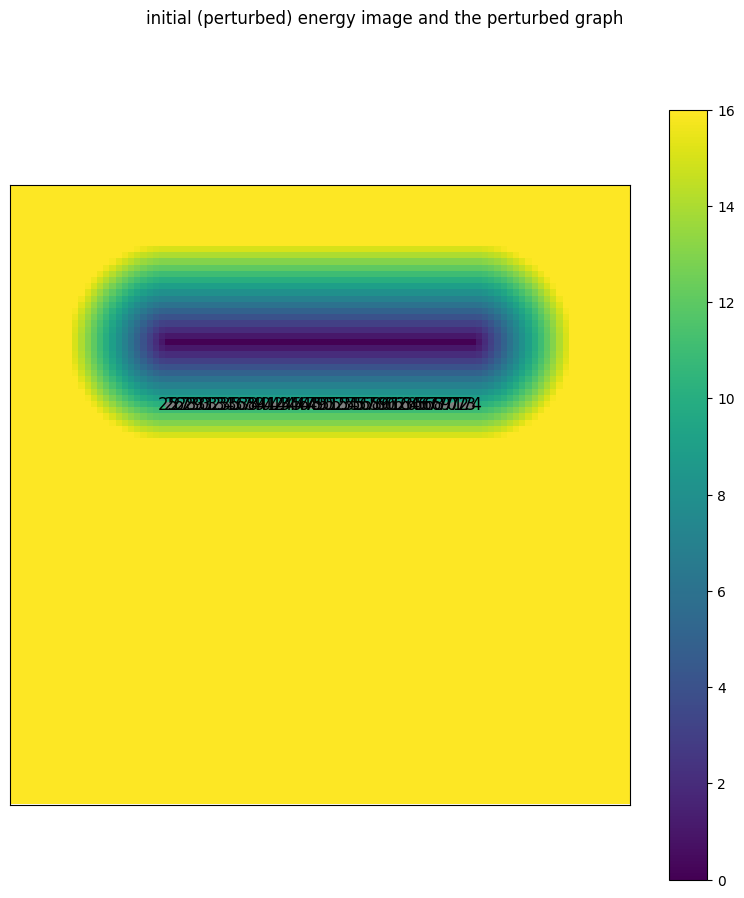

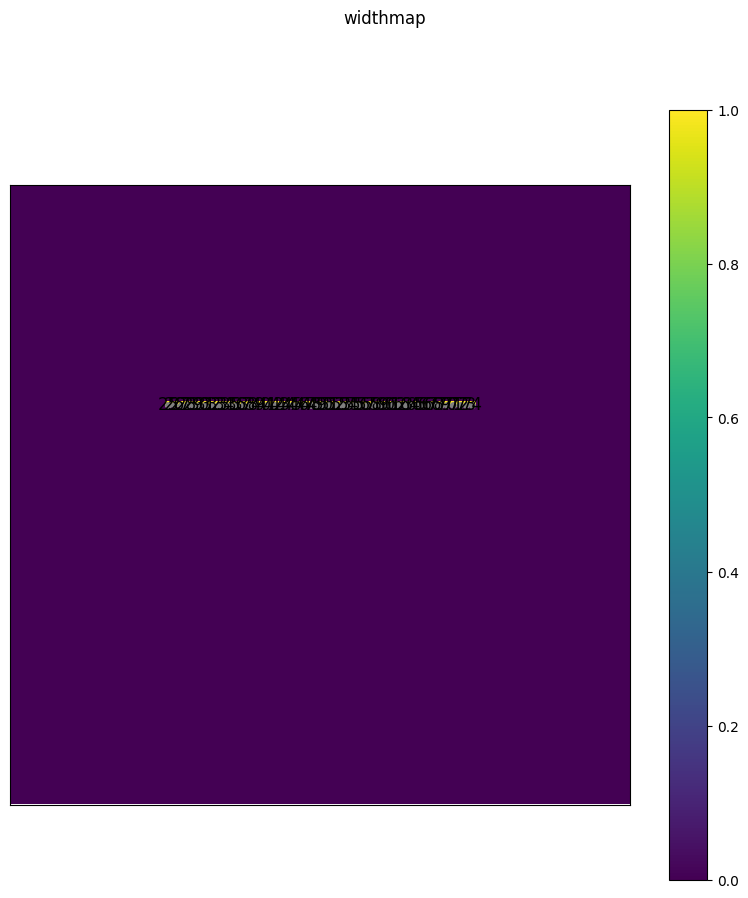

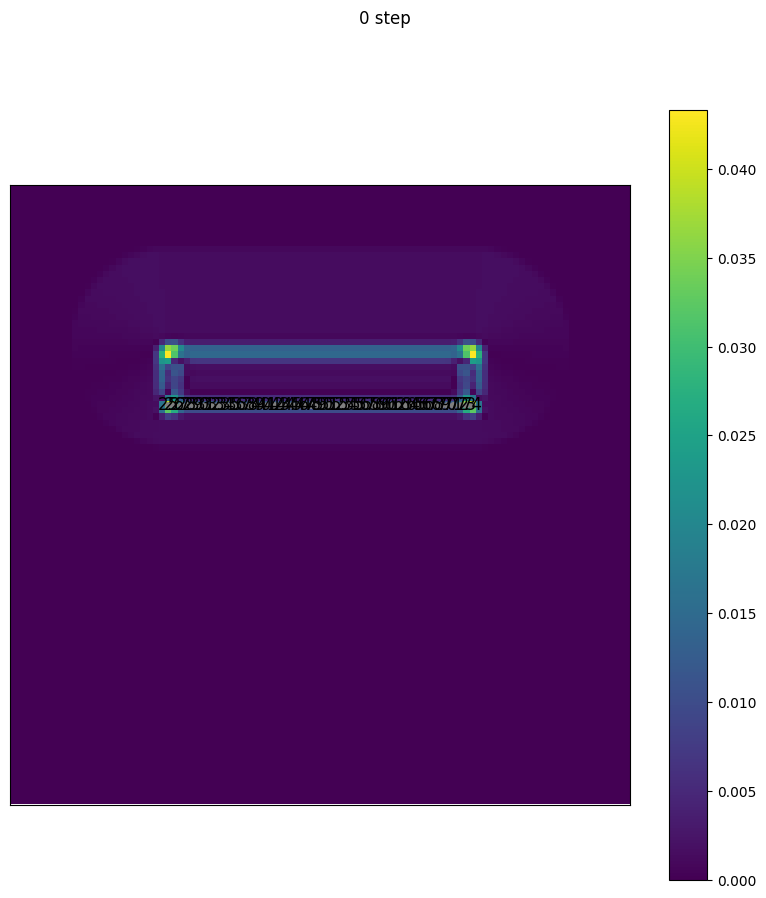

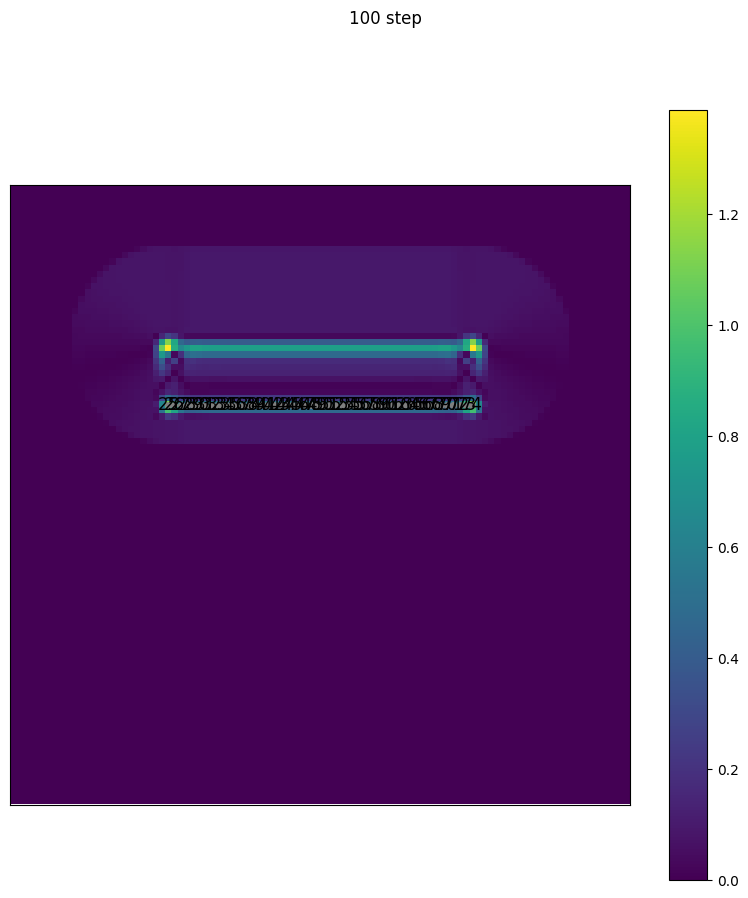

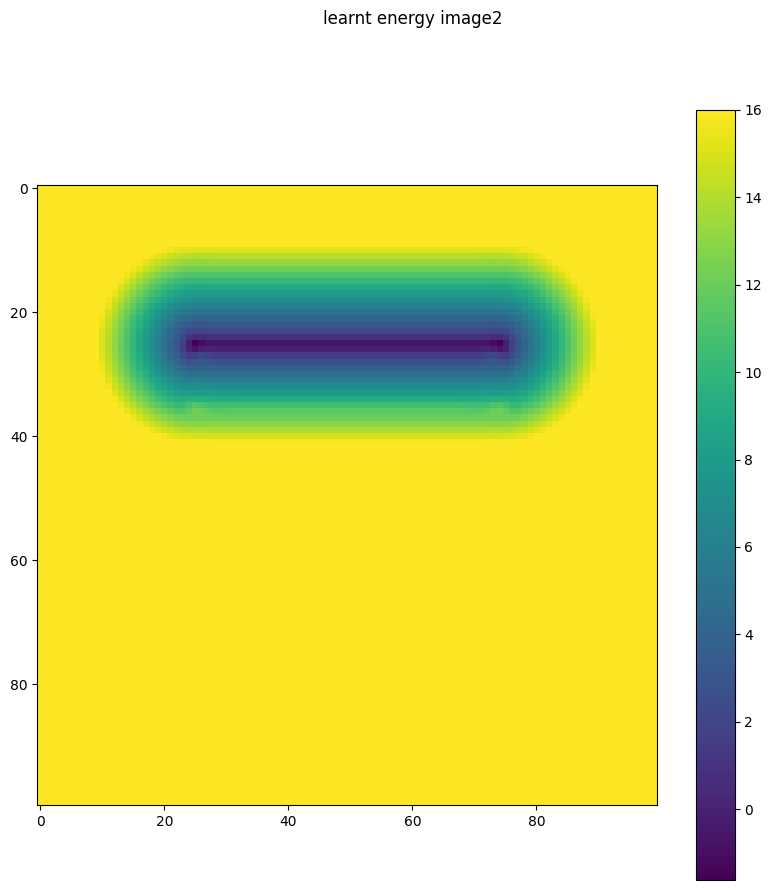

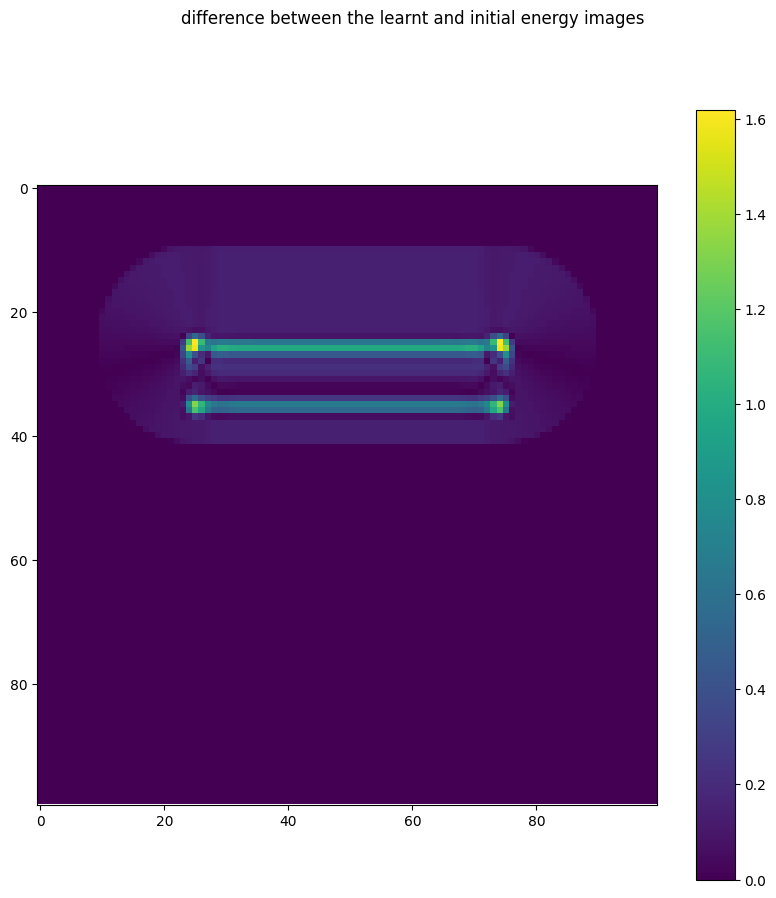

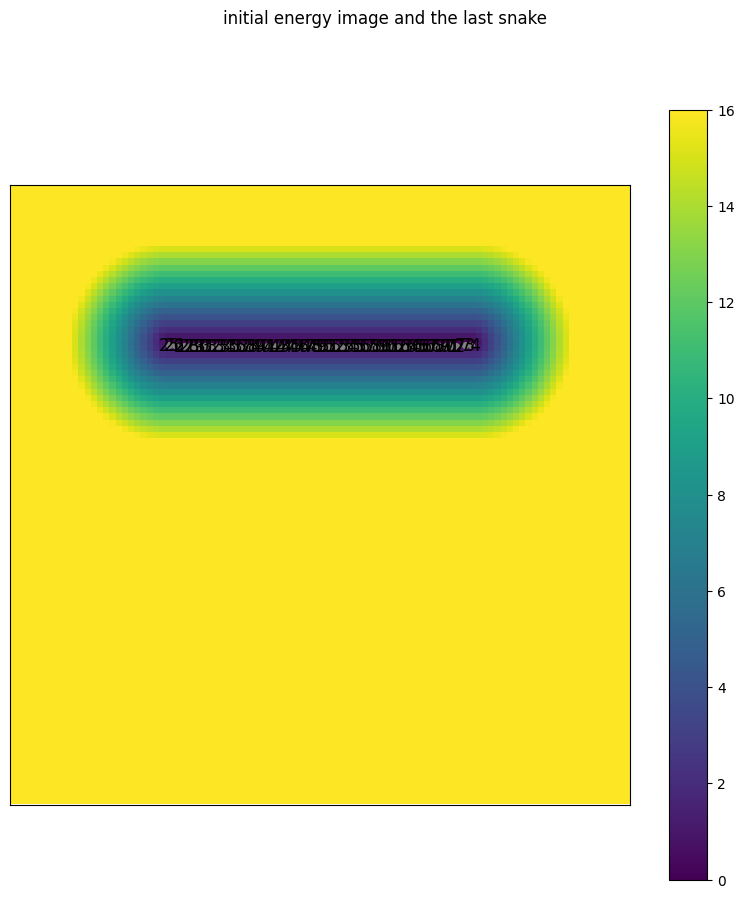

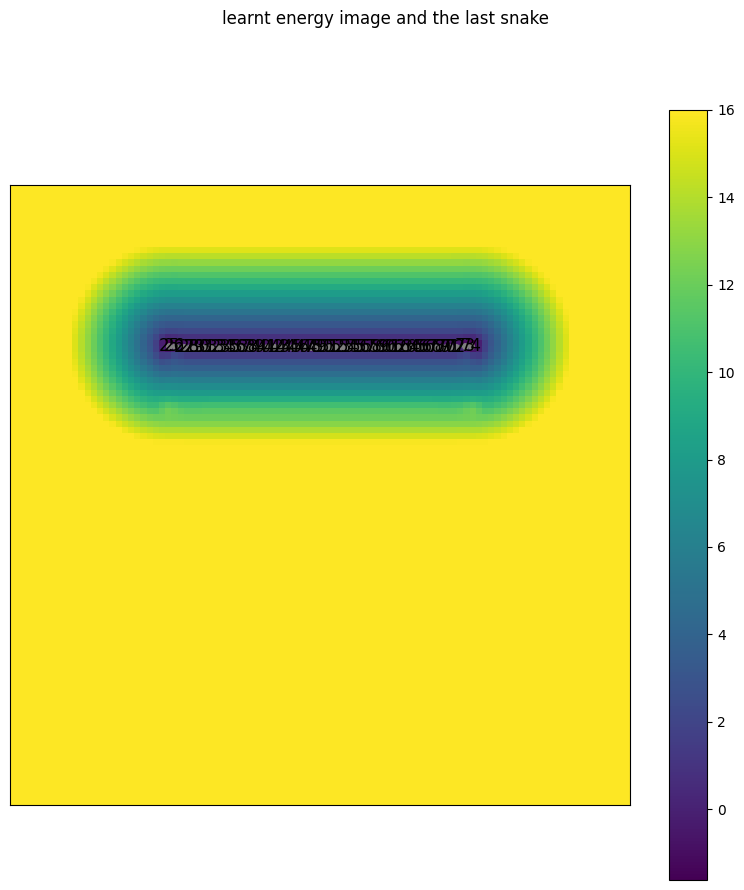

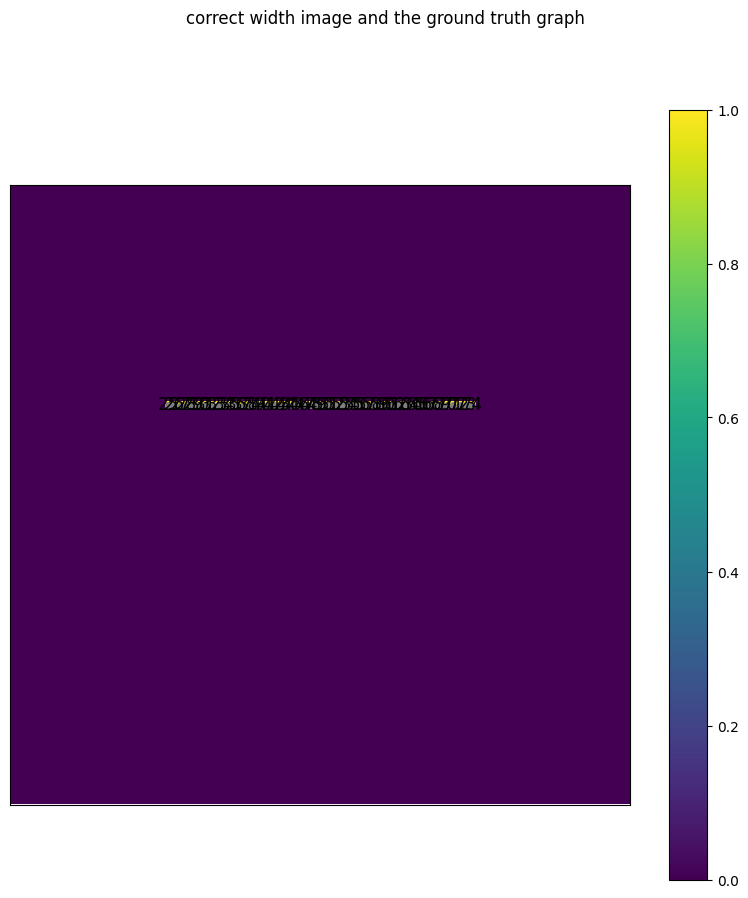

In [40]:

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
#pred_initial2[:,:,33:34,:]=16.0
""" pred_initial3=pred_perfect.clone()[None,None]

pred_initial2[:,:,33:34,:]=16.0
pred_initial3[:,:,33:34,:]=16.0
pred_initial3[:,:,63:64,:]=16.0 """

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2=pred_initial2.clone()
pred2.requires_grad_(True)
""" pred2=pred_initial2.clone()
pred3=pred_initial3.clone()
pred.requires_grad_(True)
pred2.requires_grad_(True)
pred3.requires_grad_(True) """

# predf = (pred+pred2+pred3)/3
# predf.requires_grad_(True)
# perturb the ground truth graph
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([10,0]) 

show(pred_initial[0][0].detach().numpy(),"initial (perturbed) energy image and the perturbed graph",g)
plt.colorbar()

fltrstdev=1.0

#opt = optim.SGD([pred,pred2,pred3], lr=5.0, momentum=0.0)
# pred2 is optimized
opt = optim.SGD([pred2], lr=5.0, momentum=0.0)


extgradfac=1.0
nsteps=20

loss=RibonFastLoss(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                cropsz,dmax,maxedge,extgradfac)

# 2000'e artırdım, çünkü daha baştaki 200 iyi sonuç vermiyordu
# iyi sonuç vermemsinin sebebi de tek predication kullanmam
# normalde neden 3 predictionu aynı anda kullanıyorduk?
for i in range(200):
    opt.zero_grad()
    t = time.time()
    #l=loss.forward(th.stack((pred,pred2,pred3),axis=0),[g])
    l = loss.forward(pred2, [g], i)
    # this calculates the backward for the loss to change pred2
    l.backward()
    # optimization is done on pred2
    opt.step()
    if i % 100 == 0:
        show(torch.abs(pred2-pred_initial2)[0][0].detach().numpy(),str(i)+" step",g)
        plt.colorbar()


""" show(pred[0][0].detach().numpy(),"learnt energy image")
plt.colorbar()
show(th.abs(pred-pred_initial)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar() """

show(pred2[0][0].detach().numpy(),"learnt energy image2")
plt.colorbar()
show(torch.abs(pred2-pred_initial2)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar()

""" show(pred3[0][0].detach().numpy(),"learnt energy image3")
plt.colorbar()
show(th.abs(pred3-pred_initial3)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar() """

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show(pred_initial[0][0].numpy(),"initial energy image and the last snake",
     loss.snake.getGraph())
plt.colorbar()

show(final_pred[0][0].numpy(),"learnt energy image and the last snake", loss.snake.getGraph())
plt.colorbar()

pred_dis = loss.snake.render_width_map(size, cropsz, dmax, maxedge)
show(pred_dis.numpy(), "correct width image and the ground truth graph", g)
plt.colorbar()

In [ ]:
g = nx.Graph()
for i in range(25,75):  # Start from 0
    g.add_node(i, pos=np.array([25, i]))
    if i > 25:
        g.add_edge(i, i - 1)
        
stepsz=0.33
alpha=0
beta=0
crop=[slice(0,200), slice(0,200)]
ndims=2

s=snake.Snake(g,crop,stepsz,alpha,beta,ndims)  

size=[100,100]
cropsz=[16,16]
dmax=16
maxedge=4
 
pred_perfect=s.renderDistanceMap(size,cropsz,dmax,maxedge) 
show(pred_perfect.numpy(),"correct energy image and the ground truth graph",g)
plt.colorbar()

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
#pred_initial2[:,:,33:34,:]=16.0
""" pred_initial3=pred_perfect.clone()[None,None]

pred_initial2[:,:,33:34,:]=16.0
pred_initial3[:,:,33:34,:]=16.0
pred_initial3[:,:,63:64,:]=16.0 """

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2=pred_initial2.clone()
pred2.requires_grad_(True)
""" pred2=pred_initial2.clone()
pred3=pred_initial3.clone()
pred.requires_grad_(True)
pred2.requires_grad_(True)
pred3.requires_grad_(True) """

# predf = (pred+pred2+pred3)/3
# predf.requires_grad_(True)
# perturb the ground truth graph
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([30,0]) 

show(pred_initial[0][0].detach().numpy(),"initial (perturbed) energy image and the perturbed graph",g)
plt.colorbar()

fltrstdev=1.0

#opt = optim.SGD([pred,pred2,pred3], lr=5.0, momentum=0.0)
# pred2 is optimized
opt = optim.SGD([pred2], lr=5.0, momentum=0.0)


extgradfac=1.0
nsteps=20

loss=Loss_MSE_GaussSnake_wGrad3(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                cropsz,dmax,maxedge,extgradfac)

# 2000'e artırdım, çünkü daha baştaki 200 iyi sonuç vermiyordu
# iyi sonuç vermemsinin sebebi de tek predication kullanmam
# normalde neden 3 predictionu aynı anda kullanıyorduk?
for i in range(2000):
    opt.zero_grad()
    t = time.time()
    #l=loss.forward(th.stack((pred,pred2,pred3),axis=0),[g])
    l = loss.forward(pred2, [g], i)
    # this calculates the backward for the loss to change pred2
    l.backward()
    # optimization is done on pred2
    opt.step()
    if i % 400 == 0:
        show(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),str(i)+" step",g)
        plt.colorbar()


""" show(pred[0][0].detach().numpy(),"learnt energy image")
plt.colorbar()
show(th.abs(pred-pred_initial)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar() """

show(pred2[0][0].detach().numpy(),"learnt energy image2")
plt.colorbar()
show(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar()

""" show(pred3[0][0].detach().numpy(),"learnt energy image3")
plt.colorbar()
show(th.abs(pred3-pred_initial3)[0][0].detach().numpy(),"difference between the learnt and initial energy images")
plt.colorbar() """

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show(pred_initial[0][0].numpy(),"initial energy image and the last snake",
     loss.snake.getGraph())
plt.colorbar()

show(final_pred[0][0].numpy(),"learnt energy image and the last snake", loss.snake.getGraph())
plt.colorbar()

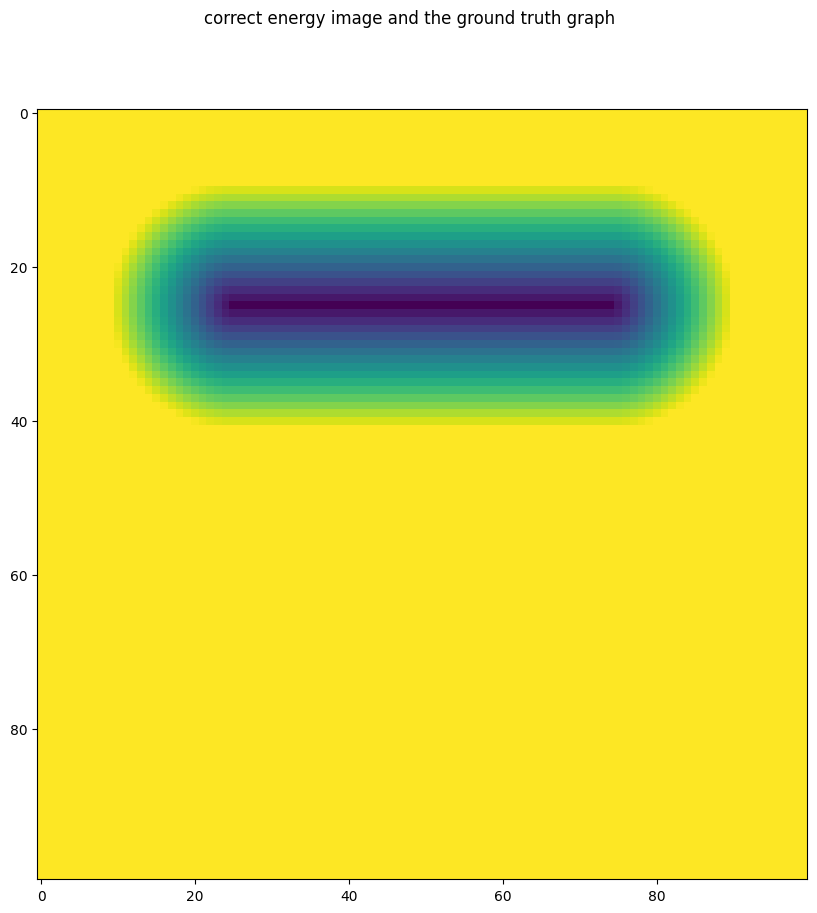

In [19]:
show(pred_perfect.numpy(),"correct energy image and the ground truth graph")

In [40]:
pred.size()

torch.Size([1, 1, 100, 100])

In [42]:
th.stack((pred,pred2,pred3),axis=1).size()

torch.Size([1, 3, 1, 100, 100])

In [21]:
predf.requires_grad

True

In [20]:
crop=[slice(0,100), slice(0,100),slice(0,100)]
size=[100,100,100]
maxedgelength=5

cropsz=[32,32,32]
dmax=15

extgradfac=1.0
nsteps=20

fltrstdev=1.0

stepsz=0.5
alpha=0.0
beta=0.1
ndims=3

loss=Loss_MSE_GaussSnake_wGrad(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                               cropsz,dmax,maxedgelength,extgradfac)

In [25]:
t = time.time()
crop=[slice(0,s) for s in pred[0].shape[1:]]
s=gradImSnake.GradImSnake(g,crop,1,0,
                          0,3,pred[0])
print(time.time()-t)

0.015004634857177734


In [34]:
pred.requires_grad_(True)
t = time.time()
l=loss(pred,[g])
l.backward()
print(time.time()-t)

3.8699231147766113


In [72]:
t = time.time()
dmap1=s.renderDistanceMap([100,100,100],[20,20,20],15,5)
print(time.time()-t)

t = time.time()
dmap2=s.renderDistanceMap([100,100,100],[32,32,32],15,5)
print(time.time()-t)

1.365755319595337
2.2594099044799805


In [70]:
th.cuda.is_available()

False

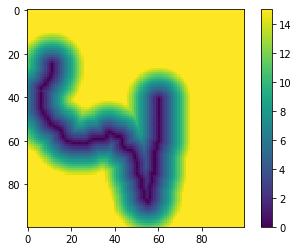

In [74]:
dmap2.shape
plt.imshow((dmap1.detach().numpy()).min(0))
plt.colorbar()

In [239]:
# x-shaped snake

from math import sin,pi
from torch import optim

nnodes=6
scale=16
margin=16
offset=margin+nnodes*scale
sz=2*offset

# create a graph 
lbl=np.zeros((sz,sz))
g=create_X_graph(nnodes,scale,offset)

crop=[slice(0,sz),slice(0,sz)]
stepsz=0.1
alpha=0.0
beta=1.0
ndims=2

s=snake.Snake(g,crop,stepsz,alpha,beta,ndims)

size=[sz,sz]
cropsz=[16,16]
dmax=16
maxedge=16
 
pred_perfect=s.renderDistanceMap(size,cropsz,dmax,maxedge)
del s

show(pred_perfect.numpy(),"original energy image and the ground truth graph",g)
plt.colorbar()

pred_initial=pred_perfect.clone()[None,None]
pred_initial[:,:,33:34,:]=16.0
pred=pred_initial.clone()
pred.requires_grad_(True)

# perturb the ground truth graph
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([4,0]) 

show(pred[0][0].detach().numpy(),"perturbed energy image and the perturbed graph", g)
plt.colorbar()

opt = optim.SGD([pred], lr=1.0, momentum=0.0)

nsteps=40

fltrstdev=1.0
extparam=1

loss=Loss_MSE_GaussSnake_wGrad(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                cropsz,dmax,maxedge,extgradfac)

for i in range(100):
    opt.zero_grad()
    l=loss.forward(pred,[g])
    l.backward()
    opt.step()
    

show(pred[0][0].detach().numpy(),"learnt energy image ")
plt.colorbar()

show(th.abs(pred-pred_initial)[0][0].detach().numpy(),"difference to initial energy image")
plt.colorbar()

final_pred=pred.detach()
show(pred_initial[0][0].numpy(),"initial energy image and the last snake",
     loss.snake.getGraph())
plt.colorbar()

#show(loss.gimg[0][0],"aa")
#show(loss.gimg[0][1],"bb")

IndexError: list index out of range

11.t7.npy
4.t7.npy
10.t7.npy
16.t7.npy


/cvlabdata2/home/oner/Snakes/brain/graph_from_skeleton/graph_from_skeleton.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.arccos((p1c*p1c+p0c*p0c-p0p1*p0p1)/(2*p1c*p0c))*180/np.pi
/cvlabdata2/home/oner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/cvlabdata2/home/oner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


RuntimeError: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

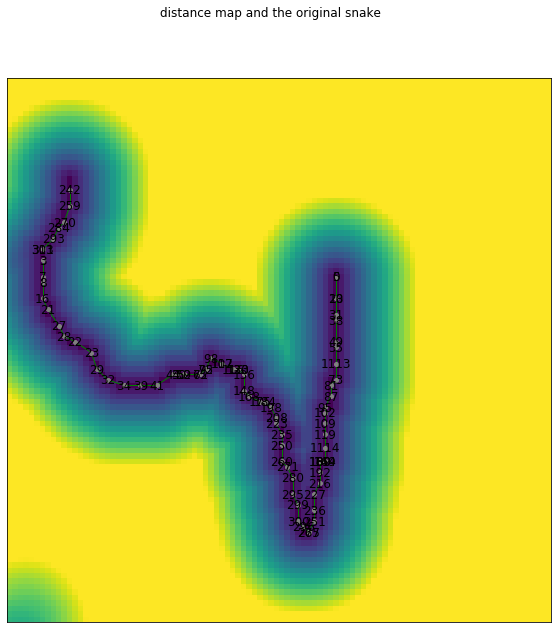

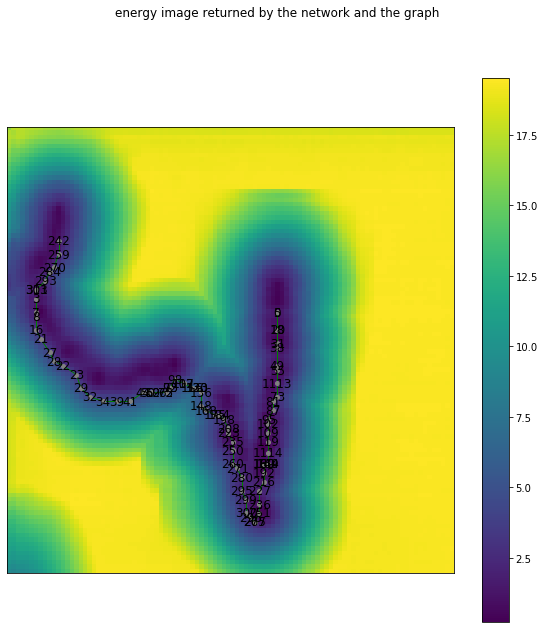

In [19]:
# a 3D example
import sys
sys.path.append("/cvlabdata2/home/oner/Snakes/brain/")
from graph_from_skeleton.graph_from_skeleton import *
from graph_from_skeleton.utils import *
from topoloss4neurons.datasets import load_dataset
from topoloss4neurons.datasets.networkSnakes import *
from scipy.ndimage.morphology import distance_transform_edt

from cropGraph import cropGraph_dontCutEdges

from copy import deepcopy

dt = load_dataset("neuron", sequence='testing', size="orig", labels="all", each=1, dist_lbl=True, graph=False, threshold=15, snakes=False)
lbl = skeletonize_3d((dt[0].label == 2)[:,:,:])
G = graph_from_skeleton.graph_from_skeleton(lbl, angle_range=(170,190), dist_line=0.00001, dist_node=3, verbose=False)
G = oversampling_graph(G, 4)

pred = np.load("/cvlabdata2/home/oner/Snakes/brain/brain_logs/log_baseline_3d_2steps/output_valid/pred_000000_bestqual.npy")[0,:,:,:]


for n in G.nodes:
    p=G.nodes[n]["pos"]
    # fix the graph
    if type(p)==tuple:
        G.nodes[n]["pos"]=np.array(list(p))

GI=G.copy()
invertCoordinates(GI)
crop=[slice(0,100), slice(0,100),slice(0,100)]
size=[100,100,100]
maxedgelength=5

cropsz=[32,32,32]
dmax=15

distlbl=distance_transform_edt(1-lbl//255)
distlbl=np.clip(distlbl,a_max=15,a_min=-1)


g=cropGraph_dontCutEdges(GI,crop)
pred=pred[crop]
distlbl=distlbl[crop]

g_orig=deepcopy(g)
show3D(distlbl,"distance map and the original snake",g_orig)


# perturb the ground truth graph
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,5,0]) 

show3D(pred,"energy image returned by the network and the graph", g)
plt.colorbar()


##########################################

#pred=th.cat([pred_1,pred_2],dim=0)
#pred.requires_grad_()
#G=[g,h]

pred=th.tensor(pred[None,None],dtype=th.double)
pred_initial=pred.clone()

G=[g]

extgradfac=1.0
nsteps=20

fltrstdev=1.0

stepsz=0.5
alpha=0.0
beta=0.1
ndims=3

loss=Loss_MSE_GaussSnake_wGrad(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                               cropsz,dmax,maxedgelength,extgradfac)

loss.cuda()
pred=pred.cuda()
pred.requires_grad_()

opt = optim.SGD([pred], lr=1, momentum=0.0)

print(pred.shape)
for i in range(10):
    opt.zero_grad()
    l=loss.forward(pred,G)
    l.backward()
    opt.step()
    

final_pred=pred.detach().cpu()
show3D(final_pred[0][0].numpy(),"final energy image and the original snake",g_orig)
plt.colorbar()
show3D(th.abs(final_pred-pred_initial)[0][0].numpy(),"difference to initial energy image and the original snake",
       g_orig,mode='max')
plt.colorbar()

show3D(pred_initial[0][0].numpy(),"initial energy image and the snake of the last loss call",
       loss.snake.getGraph(),mode='min')
plt.colorbar()


In [5]:
dt = load_dataset("synth", "training", size="train", labels="all", each=1, threshold=15, graph=True)

data_0.npy
data_1.npy
data_2.npy
data_3.npy
data_4.npy
data_5.npy
data_6.npy
data_7.npy
data_8.npy
data_9.npy
data_10.npy
data_11.npy
data_12.npy
data_13.npy
data_14.npy
data_15.npy
data_16.npy
data_17.npy
data_18.npy
data_19.npy


In [6]:
from collections import namedtuple
ExtDataPoint = namedtuple("ExtDataPoint", ['image', 'label', 'graph'])
def invertCoordinates(g):   
    for n in g.nodes:
        g.nodes[n]["pos"]=g.nodes[n]["pos"][-1::-1]
    return g

def process_dataset(dp, in_channels, val=False, snakes=True):
    if in_channels==1:
        image = dp.image[:,:,:,None]
        lbl = dp.dist_labels[:,:,:,None]
        if val:
            graph = make_graph(dp.graph, True)
        else:
            if snakes:
                graph = invertCoordinates(dp.graph)
            else:
                graph = None
        
    else:
        image = dp.image

    return ExtDataPoint(image, lbl, graph)

In [8]:
ft = lambda dp: process_dataset(dp, 1, False, True)
dt2 = [ft(dp) for dp in dt]

In [10]:
stepsz=0.1
alpha=0.01
beta=0.001
fltrstdev=0.5
extparam=1
nsteps=10
ndims=3
cropsz=[32,32,32]
dmax=15
maxedgelength=5
extgradfac=2.0

loss_function=Loss_MSE_GaussSnake_wGrad(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                        cropsz,dmax,maxedgelength,extgradfac)

In [25]:
f = []
f.append( lambda sample: nt.crop(sample, [96,96,96], "random") )
#         f.append( lambda sample: nt.random_flip(sample, axis=(0,1,2), p=(0.5,0.5,0.5)) )
images, labels, slices = nt.process_in_batch(f, [dt2[0].image], [dt2[0].label])
images2  = np.transpose(np.float32(images), (0,4,1,2,3))
labels2  = np.transpose(np.float32(labels), (0,4,1,2,3))

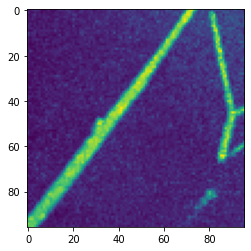

In [27]:
%matplotlib inline
plt.imshow(images[0].max(0))

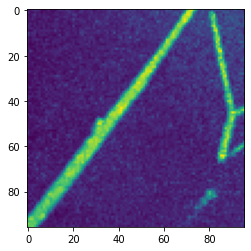

In [28]:
plt.imshow(images2[0,0].max(0))

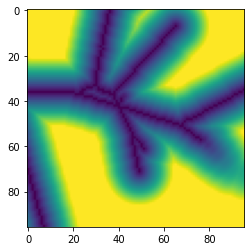

In [20]:
plt.imshow(labels[0,0].min(0))

In [22]:
labels  = nt.to_torch(labels)
l = loss_function(labels, [dt2[0].graph], slices)

In [23]:
rr = loss_function.snake.renderDistanceMap([96,96,96],cropsz,dmax,maxedgelength)

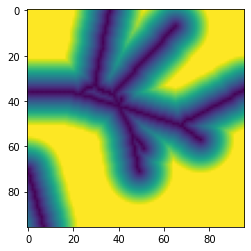

In [24]:
plt.imshow(rr.detach().numpy().min(0))